### Required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy
import math
import statistics
from numpy import random
from scipy.stats import genextreme as gev

import tensorflow as tf
from tensorflow import reduce_mean, square
import tensorflow.keras as keras
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, Dropout
import time
import pickle

### Abline function

In [2]:
def abline(slope, intercept):
    """
    Function to add a straight line to the existing plot
    Arguments:
    * slope
    * intercept
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = 'magenta')

### Generate the parameters: Shape, Scale, and Location

In [3]:
# 350k sample size
n= 340000

n_train= 300000
print("Training Size",n_train)

n_valid= 40000
print("Validation Size",n_valid)

Training Size 300000
Validation Size 40000


## Converting netcdf to csv after training and testing the NN


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# #- Sample-size Set -
# # Creating a discrete sequence of varying sample size
N_set= np.rint(10**np.linspace(start= math.log(30,10), stop=math.log(1000,10), num=5)).astype(int)
print('Discrete set of sample size', N_set)

over_all_factor= np.rint((n)/len(N_set)).astype(int)
print(over_all_factor)

Discrete set of sample size [  30   72  173  416 1000]
68000


In [ ]:
# # - Generate sample for the given factor
# # idea: generate parameters over the parameteric range of size "overall_factor"
# # and replicate it over each sample size in the N set

# random.seed(111)
# shape_vals= random.uniform(-1, 0.4, over_all_factor) # c
# scale_vals= 10**random.uniform(np.log10(0.1), np.log10(40), over_all_factor)
# loc_vals= random.uniform(1, 50, over_all_factor)

In [ ]:
# # -- parametric matrix --
# loc_values= np.hstack((loc_vals, loc_vals, loc_vals, loc_vals, loc_vals))
# scale_values= np.hstack((scale_vals, scale_vals, scale_vals, scale_vals, scale_vals))
# shape_values= np.hstack((shape_vals, shape_vals, shape_vals, shape_vals, shape_vals))

# N_values= np.repeat(N_set, over_all_factor)

To be note:

---



Generating the simulation model

 1) define a given set of sample size "N_set"

 2) total simulation size is fixed to "n"

 3) compute the overall multiple factor for each unique value of N_set

 4) generate the parameter combination (over the given range) of size "overall_factor"

 5) further generate the GEV sample on the given paramter combinations over given element of "N_set" sequenially, i.e if overall_factor is 3, generate GEV sample for the 3 parameter_combination for sample size 30 first then for 72 and so on, consequetively

 6) last, shuffle the final observation set for randomness.



In [ ]:
# parameteric_matrix= np.transpose(np.vstack((loc_values, scale_values, shape_values, N_values)))
# random.seed(123)
# random.shuffle(parameteric_matrix) # randomly shuffling

In [ ]:
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17
# np.savetxt("parameteric_matrix_-0.1_0.4.csv", parameteric_matrix, delimiter=",")

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17


In [6]:
parameteric_matrix = np.array(pd.read_csv('/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/parameteric_matrix_-1_0.4.csv', header=None))

In [7]:
loc_vals= (parameteric_matrix[:, 0])
scale_vals= (parameteric_matrix[:, 1])
shape_vals= (parameteric_matrix[:, 2])
print('Max shape value', np.max(shape_vals))
print('Min shape value', np.min(shape_vals))

N_vals= (parameteric_matrix[:, 3]).astype(int)

Max shape value 0.3999970789497518
Min shape value -0.9999426082987267


In [8]:
np.min(shape_vals)

-0.9999426082987267

In [9]:
# machine epsilon value for floating-point numbers
mch_epsilon = np.finfo(float).eps
print(mch_epsilon)

2.220446049250313e-16


In [10]:
# Assuming 'shape_vals' is a NumPy array containing the shape values
is_weibull = shape_vals > mch_epsilon
print('# of weibull =', sum(is_weibull))

is_frechet = shape_vals < -mch_epsilon
print('# of frechet =', sum(is_frechet))

is_gumbel = ~(is_weibull | is_frechet) # not weibull and not frechet
print('# of gumbel =', sum(is_gumbel))

# of weibull = 96975
# of frechet = 243025
# of gumbel = 0


In [11]:
# -- percentile  --
# selected quantiles/percentiles mainly focus on the tail of the distribution, Q1, Q2,and Q3
p_set= np.array([0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])
print(p_set.shape)

(11,)


In [12]:
# -- percentile  --
# selected quantiles/percentiles mainly focus on the tail of the distribution, Q1, Q2,and Q3

# # Set 1
p_set1 = np.array([0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
print(p_set1.shape)

# Set 2 [Original Choice]
p_set2 = np.array([0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])
print(p_set2.shape)

# # Set 3
# generating equally spaced quantile in log scale
n_len = 25
temp_p_setI= 10**np.linspace(np.log10(0.0001), np.log10(0.5),  n_len) # equispace over logarithmic scale
temp_p_setII = (1- temp_p_setI)
p_set3= np.sort(np.concatenate((temp_p_setI, temp_p_setII[0:(n_len-1)]) ) )
print(p_set3.shape)

(9,)
(11,)
(49,)


### Function to compute the Percentile Matrix

In [13]:
# -- Function to compute the Count matrix for the standardized data --
# here VS stands for varying sample size
def VS_Z_quantiles(seed, shape_vec, loc_vec, scale_vec, N_set):
    """
    Function to return 'Percentile Matrix'
    here n = n_train + n_valid + n_test.

    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape_vec, loc_vec, scale_vec = simulated shape, location, scale parameter values
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!
    * p_vec = quantile set
    * n_train = training size
    * n_valid = validation size
    * N = GEV sample generated for each parameter combination
      -> is set to 1000 for now.
    """
    # setting the seed for sample generation
    random.seed(seed)

    # Drawing sample of size N from GEV(shape, loc, scale)
    # sample size (= training + valid set + test set)
    n= len(shape_vec)

    # -- initializing the matrices & vectors --
    percentile_Matrix1= np.empty((n,len(p_set1))) # store the counts
    percentile_Matrix2= np.empty((n,len(p_set2)))
    percentile_Matrix3= np.empty((n,len(p_set3)))

    storeSample= np.empty((n, max(N_set))) # store the standardized sample
    std_storeSample= np.empty((n, max(N_set))) # store the standardized sample

    storeIQR= [] # store sample IQR
    storeMean= [] # store sample mean
    storeMedian= [] # store sample median

    # -- extracting counts --
    for i in range(n):

        # idiot numbers; just to check the loop
        if i%5525 == 0:
            print(i)

        # sample generation
        X_sample = gev.rvs(c=shape_vec[i],
                           loc=loc_vec[i],
                           scale=scale_vec[i],
                           size=N_set[i])

        # computing sample mean and sample variance
        Mean = statistics.mean(X_sample)
        Median = np.median(X_sample)
        IQR = scipy.stats.iqr(X_sample)

        storeMean.append(Mean)
        storeMedian.append(Median)
        storeIQR.append(IQR)

        # standardization of the data
        Z_sample= (X_sample-Median)/IQR

        # storing the standardized sample
        percentile_Matrix1[i,:] = np.percentile(Z_sample, p_set1*np.array(100))
        percentile_Matrix2[i,:] = np.percentile(Z_sample, p_set2*np.array(100))
        percentile_Matrix3[i,:] = np.percentile(Z_sample, p_set3*np.array(100))


        # store std sample
        if len(X_sample)==1000:
            # storing the sample
            storeSample[i, :] = X_sample # dimension n*1000
            std_storeSample[i, :] = Z_sample  # dimension n*1000
        else:
            # we are working with varying sample size
            # some elements in the matrix will have NaN values
            fill_space_NaN = np.empty((max(N_set)-len(X_sample)))
            fill_space_NaN[:] = np.NaN
            storeSample[i,:] = np.concatenate((X_sample, fill_space_NaN))
            std_storeSample[i, :] = np.concatenate((Z_sample, fill_space_NaN))  # dimension n*1000

    return storeSample, std_storeSample, percentile_Matrix1, percentile_Matrix2, percentile_Matrix3, np.array(storeMean),  np.array(storeMedian), np.array(storeIQR)

### Percentile for selected set of quantiles

In [ ]:
# # # -- Computing the Count Matrix --
# # # Working with sample size N_set
# # # record time
# start_time= time.time()
# storeSample, std_storeSample, percentileMat1, percentileMat2, percentileMat3, sampleMeans, sampleMedians, sampleIQRs = VS_Z_quantiles(seed=122,
#                                                                                                                                       shape_vec=shape_vals,
#                                                                                                                                       loc_vec=loc_vals,
#                                                                                                                                       scale_vec=scale_vals,
#                                                                                                                                       N_set=N_vals)
# tot_time_sample_sim= (time.time()-start_time)
# print("--- %s seconds ---" %tot_time_sample_sim)

In [ ]:
print('Total time taken to simulate the sample in mins', tot_time_sample_sim/3600, 'hrs')

Total time taken to simulate the sample in mins 1.9282222627931171 hrs


In [ ]:
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17
# np.savetxt("storeSampl_-1_0.4.csv", storeSample, delimiter=",")

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17


In [14]:
storeSample = np.array(pd.read_csv('/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/storeSampl_-1_0.4.csv', header=None))

In [15]:
# -- Function to compute the Count matrix for the standardized data --
n = len(shape_vals)

# -- initializing the matrices & vectors --
percentile_Matrix1 = np.empty((n,len(p_set1)))# store the counts
percentile_Matrix2 = np.empty((n,len(p_set2)))# store the counts
percentile_Matrix3 = np.empty((n,len(p_set3)))# store the counts

stdstoreSample= np.empty((n, max(N_set)))

#storeSample= np.empty((n, max(N_set))) # store the standardized sample
storeIQR = [] # store sample IQR
storeMedian = [] # store sample median

# -- extracting counts --
for i in range(n):
  # idiot numbers; just to check the loop
  if i%5525 == 0:
    print(i)

  # sample generation
  X_sample = storeSample[i,:]

  # computing sample median and sample variance
  # Mean= statistics.mean(X_sample)

  Median = np.nanmedian(X_sample)

  percentile25, percentile75 = np.nanpercentile(X_sample, q=[25, 75])
  IQR = percentile75 - percentile25

  storeMedian.append(Median)
  storeIQR.append(IQR)

  # standardization of the data
  Z_sample = (X_sample-Median)/IQR

  # storing the standardized sample
  percentile_Matrix1[i,:] = np.nanpercentile(Z_sample,
                                             p_set1*np.array(100))
  percentile_Matrix2[i,:] = np.nanpercentile(Z_sample,
                                             p_set2*np.array(100))
  percentile_Matrix3[i,:] = np.nanpercentile(Z_sample,
                                             p_set3*np.array(100))

  # store std sample
  if len(X_sample)==1000:
    # storing the sample
    stdstoreSample[i, :]= Z_sample # dimension n*1000
  else:
    # we are working with varying sample size
     # some elements in the matrix will have NaN values
     fill_space_NaN= np.empty((max(N_set)-len(X_sample)))
     fill_space_NaN[:]= np.NaN
     stdstoreSample[i,:]= np.concatenate((Z_sample, fill_space_NaN))

0
5525
11050
16575
22100
27625
33150
38675
44200
49725
55250
60775
66300
71825
77350
82875
88400
93925
99450
104975
110500
116025
121550
127075
132600
138125
143650
149175
154700
160225
165750
171275
176800
182325
187850
193375
198900
204425
209950
215475
221000
226525
232050
237575
243100
248625
254150
259675
265200
270725
276250
281775
287300
292825
298350
303875
309400
314925
320450
325975
331500
337025


In [16]:
sampleMedians = np.array(storeMedian)
sampleIQRs = np.array(storeIQR)

In [17]:
std_storeSample = stdstoreSample

### Scaled - location and scale parameter values

In [18]:
# With fixed seed, sample mean and variances are sample for all 3 different qunatile set
sc_loc_vals= (loc_vals/sampleIQRs) - (sampleMedians/sampleIQRs)
sc_scale_vals= scale_vals/sampleIQRs

In [19]:
sc_loc_vals_df= pd.DataFrame(sc_loc_vals)
sc_loc_vals_df.describe()

,0
count,340000.000000
mean,-0.218177
std,0.098334
min,-1.699249
25%,-0.260741
50%,-0.211275
75%,-0.166810
max,0.556751


In [20]:
sc_scale_vals_df= pd.DataFrame(sc_scale_vals)
sc_scale_vals_df.describe()

,0
count,340000.000000
mean,0.572776
std,0.154486
min,0.061246
25%,0.458963
50%,0.566803
75%,0.674542
max,2.278513


In [21]:
percentile_Matrix1

array([[-1.33703593, -1.07287091, -0.69927512, ...,  1.20240142,
         2.83542118,  4.56095751],
       [-0.70724084, -0.6778946 , -0.50149768, ...,  1.79522201,
         9.87765454, 19.10419032],
       [-1.79591219, -1.62529667, -1.01452163, ...,  0.94447524,
         2.48767408,  2.48875167],
       ...,
       [-0.75878854, -0.73501043, -0.52237036, ...,  1.29072088,
         3.28461372,  3.45587934],
       [-1.31260903, -1.05289559, -0.767104  , ...,  1.65657077,
         4.19543501,  5.70344027],
       [-1.66237796, -1.29442943, -0.77315021, ...,  0.89460552,
         1.72059919,  1.91404834]])

Comment: Sanity check for range of transformed scale/location value

In [22]:
# Calculate mininum and maximum of the Orginal sample
print('Dimension of the storeSample matrix', storeSample.shape)

sample_min = np.nanmin(storeSample, axis=1)
print('Dimension of the sample_min  matrix', sample_min.shape)

sample_max = np.nanmax(storeSample, axis=1)
print('Dimension of the sample_max matrix', sample_max.shape)

# Calculate mininum and maximum of the standardized sample
print('Dimension of the std_storeSample matrix', stdstoreSample.shape)

std_sample_min = np.nanmin(std_storeSample, axis=1)
print('Dimension of the std_sample_min  matrix', std_sample_min.shape)

std_sample_max = np.nanmax(std_storeSample, axis=1)
print('Dimension of the std_sample_max matrix', std_sample_max.shape)

Dimension of the storeSample matrix (340000, 1000)
Dimension of the sample_min  matrix (340000,)
Dimension of the sample_max matrix (340000,)
Dimension of the std_storeSample matrix (340000, 1000)
Dimension of the std_sample_min  matrix (340000,)
Dimension of the std_sample_max matrix (340000,)


In [23]:
len(std_sample_max )

340000

In [24]:
tempI = shape_vals*(std_sample_min-sc_loc_vals)
tempII = shape_vals*(std_sample_max-sc_loc_vals)

In [25]:
tempI = pd.DataFrame(tempI[is_frechet==True])
tempI.describe()

,0
count,243025.000000
mean,0.246301
std,0.105908
min,0.000009
25%,0.178155
50%,0.263709
75%,0.317269
max,1.736095


In [26]:
tempII = pd.DataFrame(tempII[is_weibull==True])
tempII.describe()

,0
count,96975.000000
mean,0.431578
std,0.204218
min,0.000001
25%,0.276883
50%,0.459877
75%,0.596492
max,1.598480


In [27]:
# Define delta parameter
# for frechet
# sc_sigma = c(z(1) - sc_mu) + exp(delta)
# delta = log(sc_sigma- c*(z(1)-sc_mu))
delta_frechet_vals = np.log(sc_scale_vals- shape_vals*(std_sample_min-sc_loc_vals))
print('Dimension of delta variable', delta_frechet_vals.shape)

# for weibull
# sc_sigma = c(z(n) - sc_mu) + exp(delta)
# delta = log(sc_sigma- c*(z(n)-sc_mu))
delta_weibull_vals = np.log(sc_scale_vals- shape_vals*(std_sample_max-sc_loc_vals))
print('Dimension of delta variable', delta_weibull_vals.shape)

Dimension of delta variable (340000,)
Dimension of delta variable (340000,)


In [28]:
# Define the common variable based on 'is_weibull'
delta_vals = np.where(is_weibull, delta_weibull_vals , delta_frechet_vals )

In [29]:
delta_vals_df = pd.DataFrame(delta_vals)
delta_vals_df.describe()

,0
count,340000.000000
mean,-1.531208
std,0.724353
min,-7.579969
25%,-2.068479
50%,-1.468337
75%,-0.936372
max,0.563970


In [30]:
# sampleMeans = np.reshape(sampleMeans, (-1,1))
# print('Dim of sample Means', np.shape(sampleMeans))

sampleMedians = np.reshape(sampleMedians, (-1,1))
print('Dim of sample Medians', np.shape(sampleMedians))

sampleIQRs = np.reshape(sampleIQRs, (-1,1))
print('Dim of sample IQRs', np.shape(sampleIQRs))

Dim of sample Medians (340000, 1)
Dim of sample IQRs (340000, 1)


In [31]:
# Minimum and Maximum for the Orginal Sample
sampleMin = np.reshape(sample_min, (-1,1))
print('Dim of std sample Minimum', sampleMin.shape)

sampleMax = np.reshape(sample_max, (-1,1))
print('Dimension of std sample Maximum', sampleMax.shape)

Dim of std sample Minimum (340000, 1)
Dimension of std sample Maximum (340000, 1)


In [32]:
sampleMax_df = pd.DataFrame(sampleMax)
sampleMax_df.describe()

,0
count,3.400000e+05
mean,1.574022e+03
std,5.717564e+04
min,1.248928e+00
25%,3.477248e+01
50%,6.126736e+01
75%,1.985917e+02
max,1.728369e+07


In [33]:
# Minimum and Maximum for the Standardized Sample
std_sampleMin = np.reshape(std_sample_min, (-1,1))
print('Dim of std sample Minimum', np.shape(std_sampleMin))

std_sampleMax = np.reshape(std_sample_max, (-1,1))
print('Dimension of std sample Maximum', std_sampleMax.shape)

Dim of std sample Minimum (340000, 1)
Dimension of std sample Maximum (340000, 1)


In [34]:
std_sampleMax_df = pd.DataFrame(std_sampleMax)
std_sampleMax_df.describe()

,0
count,340000.000000
mean,93.822496
std,2531.515983
min,0.514016
25%,2.635623
50%,6.371737
75%,23.489600
max,768298.004466


In [35]:
percentileMat1 = percentile_Matrix1
percentileMat2 = percentile_Matrix2
percentileMat3 = percentile_Matrix3

### Training and testing set

In [36]:
# -- Training set and Testing set --
Z_train1 = percentileMat1[range(n_train), :]
Z_valid1 = percentileMat1[range(n_train,(n_train+n_valid)), :]

Z_train2 = percentileMat2[range(n_train), :]
Z_valid2 = percentileMat2[range(n_train,(n_train+n_valid)), :]

Z_train3 = percentileMat3[range(n_train), :]
Z_valid3 = percentileMat3[range(n_train,(n_train+n_valid)), :]

# Original sample
sample_train = storeSample[range(n_train), :]
sample_valid = storeSample[range(n_train,(n_train+n_valid)), :]

# Sample Minimum
sampleMin_train = sampleMin[range(n_train)]
sampleMin_valid = sampleMin[range(n_train,(n_train+n_valid))]

# Sample Maximum
sampleMax_train = sampleMax[range(n_train)]
sampleMax_valid = sampleMax[range(n_train,(n_train+n_valid))]

# Standardized sample
std_sample_train = stdstoreSample[range(n_train), :]
std_sample_valid = stdstoreSample[range(n_train,(n_train+n_valid)), :]

# Std Sample Minimum
std_sampleMin_train = std_sampleMin[range(n_train)]
std_sampleMin_valid = std_sampleMin[range(n_train,(n_train+n_valid))]

# Std Sample Maximum
std_sampleMax_train = std_sampleMax[range(n_train)]
std_sampleMax_valid = std_sampleMax[range(n_train,(n_train+n_valid))]

# Sample Median
sampleMedians_train = sampleMedians[range(n_train)]
sampleMedians_valid = sampleMedians[range(n_train,(n_train+n_valid))]

# # Sample Mean
# sampleMeans_train = sampleMeans[range(n_train)]
# sampleMeans_valid = sampleMeans[range(n_train,(n_train+n_valid))]

# Sample IQR
sampleIQRs_train = sampleIQRs[range(n_train)]
sampleIQRs_valid = sampleIQRs[range(n_train,(n_train+n_valid))]

# stacking the location, scale and shape parameters
# Y = np.transpose((sc_loc_vals, sc_scale_vals, shape_vals))
Y = np.transpose((sc_loc_vals, delta_vals, shape_vals))
print("Dimension of Y vector/Parameter set",  Y.shape)

# Training, Validation and Testing Set
# Y: response varible here is the shape parameter
Y_train = Y[range(n_train), :]
print("Dimension of Y train",  Y_train.shape)
Y_valid = Y[range(n_train,(n_train+n_valid)), :]
print("Dimension of Y valid",  Y_valid.shape)

Dimension of Y vector/Parameter set (340000, 3)
Dimension of Y train (300000, 3)
Dimension of Y valid (40000, 3)


In [ ]:
#shape_vals_test= shape_vals[range((n_train+n_valid),n)]
#scale_vals_test= scale_vals[range((n_train+n_valid),n)]
#loc_vals_test= loc_vals[range((n_train+n_valid),n)]
#parameter_test= np.transpose((loc_vals_test, scale_vals_test, shape_vals_test))

#np.savetxt("parameter_test.csv", parameter_test, delimiter=",")
#np.savetxt("sample_test.csv", sample_test, delimiter=",")

## Model Build-Up

### Input Size and Network Optimizer

In [47]:
# Input size for the network
input_shape= len(p_set3)
#input_shape= np.shape(covariateMat)[1]

# Optimizers with learning rate `1e-3'
optimizer= RMSprop(learning_rate = 1e-3)

In [46]:
del model

###  Model

In [48]:
from sklearn.model_selection import train_test_split

# Clear session and set seed
tf.keras.backend.clear_session()
tf.random.set_seed(122)

# Initializer
initializer = tf.keras.initializers.GlorotUniform()

hidden_layers = [Dense(512, activation='relu', name='layer1', kernel_initializer=initializer), # changed from 256 to 512
                 Dense(512, activation='relu', name='layer2', kernel_initializer=initializer), #  changed from 256 to 512
                 #Dense(512, activation='relu', name='layer3', kernel_initializer=initializer), # extra just added now
                 #Dense(512, activation='relu', name='layer4', kernel_initializer=initializer),
                 #Dense(512, activation='relu', name='layer5', kernel_initializer=initializer),  # changed from 256 to 128
                 Dense(512, activation='relu', name='layer3', kernel_initializer=initializer),
                 Dense(128, activation='relu', name='layer4', kernel_initializer=initializer),
                 Dense(128, activation='relu', name='layer5', kernel_initializer=initializer),]
                 #Dense(3, activation='tanh', name='layer5'),]


#  [Dense(512, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#                  Dense(512, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#                  Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#                  Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#                  Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#                  Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01)),]


# Input layer
input_layer = Input(shape=input_shape, name='inputlayer')

# Pass through hidden layers
x = input_layer
for hidden_layer in hidden_layers:
    x = hidden_layer(x)
   #  x = BatchNormalization()(x)  # Batch normalization after each hidden layer

# Output layer with quantile loss
output_layer = Dense(units=3, activation='linear', name='outputlayer')(x)

# Create the model with Adam optimizer and quantile loss
model = Model(input_layer, output_layer)

In [ ]:
# # Input size for the network
# input_shape= len(p_set1)
# #input_shape= np.shape(covariateMat)[1]

# # Optimizers with learning rate `1e-3'
# optimizer= RMSprop(learning_rate = 1e-3)

In [ ]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
# extracting the initial weights
initial_weights= model.get_weights()

In [50]:
## -- using RMSprop optimizer --
model.compile(optimizer=optimizer, loss= 'mse', weighted_metrics=[]) # although our model uses the custom loss

In [51]:
# -- Callbacks --
# paitence = # of epochs with no improvement after which training will be stopped
early_stopping= EarlyStopping(monitor='val_loss',
                              patience=8, # previous 8
                              mode='min')
# paitence = # of epochs with no improvement after which learning rate will be reduced
reduce_lr_on_plateau= ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=3,
                                        mode='min')

In [52]:
tf.config.run_functions_eagerly(True) # to pass numpy() in tensorflow evnr

### Fitting the model

In [54]:
# resetting the model parameters back to their original
# record time
start_time = time.time()

model.set_weights(initial_weights)
n_epoch = 150

batch_size = 128 # change from 64 to 128

# training set
tensors_train = Z_train3, Y_train
train_dataset = tf.data.Dataset.from_tensor_slices(tensors_train).batch(batch_size)

# validation set
tensors_valid = Z_valid3, Y_valid
valid_dataset = tf.data.Dataset.from_tensor_slices(tensors_valid).batch(batch_size)


history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=n_epoch,
                    callbacks=[early_stopping, reduce_lr_on_plateau])

print("--- %s seconds ---" % (time.time() - start_time))
time_train = (time.time() - start_time)

Epoch 1/150
2344/2344 [==============================] - 126s 52ms/step - loss: 98.4682 - val_loss: 0.3792 - lr: 0.0010
Epoch 2/150
2344/2344 [==============================] - 122s 52ms/step - loss: 0.1324 - val_loss: 0.0598 - lr: 0.0010
Epoch 3/150
2344/2344 [==============================] - 121s 51ms/step - loss: 0.0730 - val_loss: 0.0627 - lr: 0.0010
Epoch 4/150
2344/2344 [==============================] - 120s 51ms/step - loss: 0.0540 - val_loss: 0.0464 - lr: 0.0010
Epoch 5/150
2344/2344 [==============================] - 121s 52ms/step - loss: 0.0491 - val_loss: 0.0489 - lr: 0.0010
Epoch 6/150
2344/2344 [==============================] - 119s 51ms/step - loss: 0.0483 - val_loss: 0.0457 - lr: 0.0010
Epoch 7/150
2344/2344 [==============================] - 120s 51ms/step - loss: 0.0478 - val_loss: 0.0450 - lr: 0.0010
Epoch 8/150
2344/2344 [==============================] - 120s 51ms/step - loss: 0.0471 - val_loss: 0.0440 - lr: 0.0010
Epoch 9/150
2344/2344 [========================

In [65]:
# set3
print('Time to train the network on 350k observation size', time_train/3600,'hrs')

Time to train the network on 350k observation size 1.6556403317716386 hrs


In [66]:
model.optimizer.lr.numpy()

1.0000001e-12

###  Attempt to save the neural model


In [67]:
pip install pyyaml h5py  # Required to save models in HDF5 format

In [68]:
# Save model
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
model.save('my_model-VSS-based-on-Andrew-suggestion-shape-1-set3.h5')

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


In [16]:
# Load the saved model from file
# with keras.utils.custom_object_scope({'CustomModel': CustomModel}):
model = keras.models.load_model('/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2/my_model-VSS-based-on-Andrew-suggestion-shape-1.h5')

In [ ]:
# Load the saved model
#model = tf.keras.models.load_model('/content/drive/My Drive/Data storage - Paper 1/trained_VSS_set2.h5')

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputlayer (InputLayer)     [(None, 11)]              0         
                                                                 
 layer1 (Dense)              (None, 512)               6144      
                                                                 
 layer2 (Dense)              (None, 512)               262656    
                                                                 
 layer3 (Dense)              (None, 512)               262656    
                                                                 
 layer4 (Dense)              (None, 128)               65664     
                                                                 
 layer5 (Dense)              (None, 128)               16512     
                                                                 
 outputlayer (Dense)         (None, 3)                 387   

### Plots for checking the network behavior

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print(f"Training loss on the final epoch was: {history.history['loss'][-1]:0.4f}")
plt.show()

NameError: ignored

### Evaluating model at the testing set

Importing regular grid to generate GEV sample for sample size 30, 173, 1000, each of size 8000

In [19]:
# -- Function to compute the Percentile matrix along with the summary variables for the generated dataset --
def Z_quantiles(seed, shape_vec, loc_vec, scale_vec, N):
    """
    Function to return 'Percentile Matrix'
    here n = n_train + n_valid + n_test.

    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape_vec, loc_vec, scale_vec = simulated shape, location, scale parameter values
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!
    * p_vec = quantile set
    * n_train = training size
    * n_valid = validation size
    * N = GEV sample generated for each parameter combination
      -> is set to 1000 for now.
    """
    # setting the seed for sample generation
    random.seed(seed)

    # Drawing sample of size N from GEV(shape, loc, scale)
    # sample size (= training + valid set + test set)
    n= len(shape_vec)

    # -- initializing the matrices & vectors --
    percentile_Matrix1 = np.empty((n,len(p_set1))) # store the counts
    percentile_Matrix2 = np.empty((n,len(p_set2))) # store the counts
    percentile_Matrix3 = np.empty((n,len(p_set3))) # store the counts

    storeSample= np.empty((n,N))  # store the standardized sample
    storeStdSample= np.empty((n,N))  # store the standardized sample
    storeIQR= [] # store sample IQR
    storeMedian= [] # store sample median
    storeZmin= []
    storeZmax= []
    #storeMean= [] # store sample mean

    # -- extracting counts --
    for i in range(n):

        # idiot numbers; just to check the loop
        if i%5525 == 0:
            print(i)

        # sample generation
        X_sample= gev.rvs(c=shape_vec[i],
                          loc=loc_vec[i],
                          scale=scale_vec[i],
                          size=N)

        # computing sample mean and sample variance
        # Mean= statistics.mean(X_sample)
        Median= statistics.median(X_sample)
        IQR= scipy.stats.iqr(X_sample)

        storeMedian.append(Median)
        storeIQR.append(IQR)

        # standardization of the data
        Z_sample= (X_sample-Median)/IQR
        storeSample[i, :]= X_sample  # dimension n*1000
        storeStdSample[i, :]= Z_sample  # dimension n*1000
        storeZmin.append(np.min(Z_sample))
        storeZmax.append(np.max(Z_sample))

        # storing the standardized sample
        percentile_Matrix1[i,:] = np.percentile(Z_sample, p_set1*np.array(100))
        percentile_Matrix2[i,:] = np.percentile(Z_sample, p_set2*np.array(100))
        percentile_Matrix3[i,:] = np.percentile(Z_sample, p_set3*np.array(100))

    return storeSample, storeStdSample, percentile_Matrix1, percentile_Matrix2, percentile_Matrix3, np.array(storeMedian), np.array(storeIQR), np.array(storeZmin), np.array(storeZmax)

In [20]:
n_test=10000
random.seed(123)
shape_test = random.uniform(-1, 0.4, n_test)
scale_test = 10**random.uniform(np.log10(0.1), np.log10(40), n_test)
loc_test = random.uniform(1, 50, n_test)

In [21]:
# Working with sample size N
N = 1000

# record time
start_time = time.time()
storeSampleTest, storeStdSampleTest, percentile_Mat1Test, percentile_Mat2Test, percentile_Mat3Test, sampleMediansTest, sampleIQRsTest, sampleZminTest, sampleZmaxTest = Z_quantiles(seed=122,
                                                                                                                                                                                    shape_vec=shape_test,
                                                                                                                                                                                    loc_vec=loc_test,
                                                                                                                                                                                    scale_vec=scale_test,
                                                                                                                                                                                    N=N)
tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
5525
--- 16.3968403339386 seconds ---


In [22]:
# With fixed seed, sample mean and variances are sample for all 3 different qunatile set
sc_loc_test= (loc_test/sampleIQRsTest) - (sampleMediansTest/sampleIQRsTest)
sc_scale_test= scale_test/sampleIQRsTest

# Define delta parameter
# for frechet
# sc_sigma = c(z(1) - sc_mu) + exp(delta)
# delta = log(sc_sigma- c*(z(1)-sc_mu))
delta_frechet_test = np.log(sc_scale_test - shape_test*(sampleZminTest - sc_loc_test))
print('Dimension of delta variable', delta_frechet_test.shape)

# for weibull
# sc_sigma = c(z(n) - sc_mu) + exp(delta)
# delta = log(sc_sigma- c*(z(n)-sc_mu))
delta_weibull_test = np.log(sc_scale_test - shape_test *(sampleZmaxTest - sc_loc_test))
print('Dimension of delta variable', delta_weibull_test.shape)

# delta
delta_test = np.where(shape_test > mch_epsilon, delta_weibull_test, delta_frechet_test)

# stacking the location, scale and shape parameters
Y_test= np.transpose((sc_loc_test, delta_test, shape_test))

Dimension of delta variable (10000,)
Dimension of delta variable (10000,)


In [24]:
tensors_test= percentile_Mat2Test, Y_test
batch_size = 128
#, storeSampleTest,
test_dataset= tf.data.Dataset.from_tensor_slices(tensors_test).batch(batch_size)
model.evaluate(test_dataset, batch_size=batch_size)

79/79 [==============================] - 0s 3ms/step - loss: 0.0159


0.015882015228271484

In [27]:
pred_vals= model.predict(percentile_Mat2Test)

313/313 [==============================] - 1s 2ms/step


In [28]:
# -- Location, Scale, and Shape predictions
sc_loc_pred_vals= pred_vals[:,0]
delta_pred_vals = pred_vals[:,1]
shape_pred_vals= pred_vals[:,2]

print('Length of Loc Pred', len(sc_loc_pred_vals))
print('Length of Scale Pred', len(delta_pred_vals))
print('Length of Shape Pred', len(shape_pred_vals))

Length of Loc Pred 10000
Length of Scale Pred 10000
Length of Shape Pred 10000


In [29]:
is_weibull_pred_vals = shape_pred_vals > mch_epsilon
sc_scale_frechet_pred_vals = (shape_pred_vals*(sampleZminTest - sc_loc_pred_vals)) + np.exp(delta_pred_vals)
sc_scale_weibull_pred_vals = (shape_pred_vals*(sampleZmaxTest - sc_loc_pred_vals)) + np.exp(delta_pred_vals)

sc_scale_pred_vals = np.where(is_weibull_pred_vals, sc_scale_weibull_pred_vals, sc_scale_frechet_pred_vals)

In [30]:
loc_pred_vals= (np.array(sc_loc_pred_vals).reshape((-1,1))*np.array(sampleIQRsTest).reshape((-1,1)) ) + sampleMediansTest.reshape((-1,1))
scale_pred_vals= np.array(sc_scale_pred_vals).reshape((-1,1))*np.array(sampleIQRsTest).reshape((-1,1))

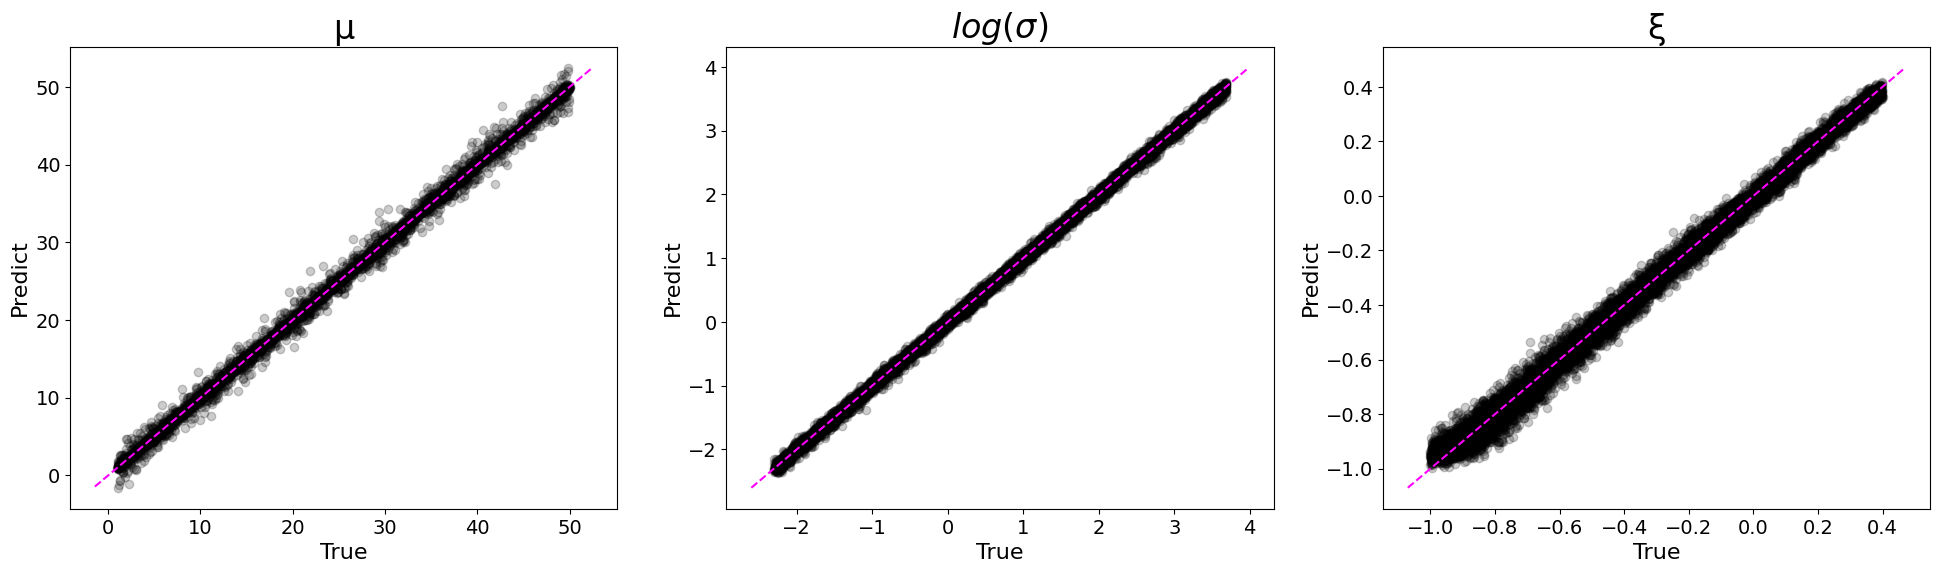

In [31]:
f= plt.figure(figsize=(24, 6))

plt.subplot(1,3,1)
scatter1= plt.scatter(loc_test,
                      loc_pred_vals,
                      color= 'black',
                      alpha=0.20)
plt.tick_params(axis='x', labelsize=14) #change axis font
plt.tick_params(axis='y', labelsize=14) #change axis font
plt.title(chr(956), fontsize=24) # to add character \mu= chr(956) in the title
plt.xlabel('True', fontsize=16)  #set axis label font
plt.ylabel('Predict', fontsize=16)  #set axis label font
abline(1, 0)

plt.subplot(1,3,2)
# scatter2= plt.scatter(np.exp(delta_test),
#                       np.exp(delta_pred_vals),
#                       color= 'black',
#                       alpha=0.20)
scatter2= plt.scatter(np.log(scale_test),
                      np.log(scale_pred_vals),
                      color= 'black',
                      alpha=0.20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(r"$\mathit{log}$($\sigma$)", fontsize=24)
plt.xlabel('True', fontsize=16)
plt.ylabel('Predict', fontsize=16)
abline(1, 0)

plt.subplot(1,3,3)
scatter3= plt.scatter(shape_test,
                      shape_pred_vals,
                      color= 'black',
                      alpha=0.20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(chr(958), fontsize=24)
plt.xlabel('True',fontsize=16)
plt.ylabel('Predict', fontsize=16)
abline(1, 0)

plt.show()
#f.savefig('Using3DiffAF-Mean-IQR-Fixed-Sample1000.jpg', bbox_inches='tight',dpi=1200)

In [32]:
# Assuming 'shape_vals' is a NumPy array containing the shape values
is_weibull_pred = shape_pred_vals > mch_epsilon
print('# of weibull =', sum(is_weibull_pred))

is_frechet_pred = shape_pred_vals < -mch_epsilon
print('# of frechet =', sum(is_frechet_pred))

shape_pred_weibull = shape_pred_vals[is_weibull_pred ]
shape_pred_frechet = shape_pred_vals[is_frechet_pred ]

sample_test_min = np.min(storeSampleTest, axis=1)
sample_test_max = np.min(storeSampleTest, axis=1)

# Check for violation in Domain constrain of GEV distribution
mch_epsilon = np.finfo(float).eps
print(mch_epsilon)

is_weibull_pred = shape_pred_vals > mch_epsilon
is_frechet_pred = shape_pred_vals < -mch_epsilon

## Check for violation in domain condition
temp = loc_pred_vals.flatten() + (scale_pred_vals.flatten()/shape_pred_vals.flatten())

temp_frechet = (temp[is_frechet_pred==True])
temp_weibull = (temp[is_weibull_pred==True])

sample_test_min_frechet = sample_test_min[is_frechet_pred==True]
sample_test_max_weibull = sample_test_max[is_weibull_pred==True]

I_frechet = np.greater(sample_test_min_frechet, temp_frechet)
A_frechet = np.sum(I_frechet) #(test size, ) # taking intersection of all the event

I_weibull = np.less(sample_test_max_weibull, temp_weibull)
A_weibull = np.sum(I_weibull) #(test size, ) # taking intersection of all the event


# T otal # violation in domain constrain
TV= (I_weibull.shape[0]+I_frechet.shape[0] - A_weibull- A_frechet)
print('# of Violation',TV)

# if TV>0:
#   print('Overall violation in domain constrain (in %)', (TV*100/(I_weibull.shape[0]+I_frechet.shape[0])))

# of weibull = 2746
# of frechet = 7254
2.220446049250313e-16
# of Violation 0


In [ ]:
# test_parameter_confg = pd.read_csv("grid_loc_0.csv") # regular grid
# test_parameter_confg.columns = ["scale", "shape"]

##  Evaluate model on test set on sample size: 30, 72, 173, 416, 1000

In [33]:
# Generating the parameter configuration for evaluation of the network architecture
# we want to set on a 20X20 grid across the scale and shape parameter
test_grid_size= 20
shape_vals= np.linspace(-1, 0.4, test_grid_size) # changed from -1 to -0.8
scale_vals= 10**np.linspace(np.log10(0.1), np.log10(40), test_grid_size)

from itertools import product
# loc value = 0
# Get all combinations using itertools.product()
grid_scale_shape = np.array(list(product(scale_vals, shape_vals)))
print(grid_scale_shape.shape)

# Perhaps the test parameters to evaluate the NN are:
loc_test = np.repeat(0, len(grid_scale_shape[:,1]))
scale_test= grid_scale_shape[:,0]
shape_test= grid_scale_shape[:,1]

print('loc_test', loc_test.shape)
print('scale_test', scale_test.shape)

(400, 2)
loc_test (400,)
scale_test (400,)


In [ ]:
# # Function that returns delta and sc_loc_parameter
# def return_delta_sc_loc_sc_scale_parameters(loc_vec, scale_vec, shape_vec, sample, std_sample):
#   # -- initializing the matrices & vectors --
#   Median_vec = np.median(sample, axis= 1)
#   IQR_vec= scipy.stats.iqr(sample, axis= 1)

#   # Median_broadcasted = np.expand_dims(Median_vec, axis=1)  # Shape: (4000, 1)
#   # IQR_broadcasted = np.expand_dims(IQR_vec, axis=1)  # Shape: (4000, 1)
#   # Standardized sample calculation
#   #Std_sample = (sample - Median_broadcasted) / IQR_broadcasted

#   #Std_sample = (sample - Median_vec)/IQR_vec # standardized sample

#   # Calculate the Std sample minimum and maximum
#   Std_sample_min = np.min(std_sample, axis=1)
#   Std_sample_max = np.max(std_sample, axis=1)

#   # defining Weibull/Frechet distribution based on shape sign
#   # machine epsilon value for floating-point numbers
#   mch_epsilon = np.finfo(float).eps

#   # Assuming 'shape_vals' is a NumPy array containing the shape values
#   is_weibull_vec = shape_vec > mch_epsilon
#   is_frechet_vec = shape_vec < -mch_epsilon

#   # defining scaled location and scale parameter
#   sc_loc_vec = (loc_vec/IQR_vec) - (Median_vec/IQR_vec)
#   sc_scale_vec = scale_vec/IQR_vec

#   delta_frechet_vec = np.log(sc_scale_vec- shape_vec*( Std_sample_min - sc_loc_vec))
#   delta_weibull_vec = np.log(sc_scale_vec- shape_vec*(Std_sample_max -sc_loc_vec))

#   delta_vec = np.where(is_weibull_vec, delta_weibull_vec , delta_frechet_vec)

#   return sc_loc_vec, sc_scale_vec, delta_vec

In [ ]:
# sc_loc, sc_scale, delta = return_delta_sc_loc_sc_scale_parameters(loc_vals[range(n_train,(n_train+n_valid))], scale_vals[range(n_train,(n_train+n_valid))], shape_vals[range(n_train,(n_train+n_valid))], sample_valid, std_sample_valid)

## Evaluate in model in sample size: 30, 72, 173, 416, 1000

In [34]:
# Generating the parameter configuration for evaluation of the network architecture
# we want to set on a 20X20 grid across the scale and shape parameter
test_grid_size= 20
shape_vals= np.linspace(-1, 0.4, test_grid_size) # changed from -1 to -0.8
scale_vals= 10**np.linspace(np.log10(0.1), np.log10(40), test_grid_size)

from itertools import product
# loc value = 0
# Get all combinations using itertools.product()
grid_scale_shape = np.array(list(product(scale_vals, shape_vals)))
print(grid_scale_shape.shape)

# Perhaps the test parameters to evaluate the NN are:
loc_test = np.repeat(0, len(grid_scale_shape[:,1]))
scale_test= grid_scale_shape[:,0]
shape_test= grid_scale_shape[:,1]

print('loc_test', loc_test.shape)
print('scale_test', scale_test.shape)

(400, 2)
loc_test (400,)
scale_test (400,)


In [ ]:
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS
np.savetxt("test_parameter_configuration.csv",  grid_scale_shape , delimiter=",")

### Test sample for sample size 30

In [35]:
# -- Generating sample for repetition -- #
# Function to compute the Count matrix for the standardized data along with the original sample
def repeated_Z_quantiles_plus_sample(seed, shape, loc, scale, p_vec, N, M):
    """
    Function to return 'Quantile matrix' for different simulated sample over same parameter
    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape, loc, scale_vec = simulated shape, location, scale parameter value
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!

    * p_vec = quantile set
    * N = GEV sample generated for each parameter combination
      -> is set to 100 for now.
    * M = no of repeatation in general
    """
    # setting the seed for sample generation
    random.seed(seed)

    # -- initializing the matrices & vectors --
    percentile_Matrix= np.empty((M,len(p_vec)))# store the counts
    storeSample= np.empty((M, 1000)) # store original sample
    storeStdSample= np.empty((M, 1000)) # store original sample

    storeIqr= [] # store sample IQR
    storeMean= [] # store sample MEAN
    storeMedian= [] # store sample MEDIAN

    # -- extracting counts --
    for i in range(M):

        # sample generation
        X_sample= gev.rvs(c=shape,
                          loc=loc,
                          scale=scale,
                          size=N)

        # computing sample Median and IQR
        Mean_sample= statistics.mean(X_sample)
        Median_sample= np.median(X_sample)
        Iqr_sample= scipy.stats.iqr(X_sample)

        storeMean.append(Mean_sample)
        storeMedian.append(Median_sample)
        storeIqr.append(Iqr_sample)

        # standardization of the data
        Z_sample= (X_sample-Median_sample)/Iqr_sample
        percentile_Matrix[i,:]= np.percentile(Z_sample, p_vec*np.array(100))

        # store std sample
        if len(X_sample)==1000:
            # storing the sample
            storeSample[i, :]= X_sample # dimension n*1000
            storeStdSample[i, :]= Z_sample # dimension n*1000
        else:
            # we are working with varying sample size
            # some elements in the matrix will have NaN values
            fill_space_NaN= np.empty((1000-len(X_sample)))
            fill_space_NaN[:]= np.NaN
            storeSample[i,:]= np.concatenate((X_sample, fill_space_NaN))
            storeStdSample[i, :] = np.concatenate((Z_sample, fill_space_NaN))

    return storeSample, storeStdSample, percentile_Matrix, np.array(storeMean), np.array(storeMedian), np.array(storeIqr)

Previous working with 100 replications, but later decided to work with 1000 repetition, because of Sampling Error

In [ ]:
## Generating the parameter configuration for evaluation of the network architecture
## we want to set on a 20X20 grid across the scale and shape parameter
# test_grid_size= 20
# shape_vals= np.linspace(-0.7, 0.4, test_grid_size) # changed from -1 to -0.8
# scale_vals= 10**np.linspace(np.log10(0.1), np.log10(40), test_grid_size)

## from itertools import product
## loc value = 0
## Get all combinations using itertools.product()
#grid_scale_shape = np.array(list(product(scale_vals, shape_vals)))
#print(grid_scale_shape.shape)

## Perhaps the test parameters to evaluate the NN are:
#loc_test = np.repeat(0, len(grid_scale_shape[:,1]))
#scale_test= grid_scale_shape[:,0]
#shape_test= grid_scale_shape[:,1]

#print('loc_test', loc_test.shape)
#print('scale_test', scale_test.shape)
#print('shape_test', shape_test.shape)

In [36]:
np.min(shape_test)

-1.0

In [38]:
## # -- Computing the Count Matrix --
# # Working with sample size N_set
# # record time
batch_size= 128

M = 100 # M stand for the number of repitition

pred_loc_30_= np.empty((len(shape_test), M))
pred_shape_30_= np.empty((len(shape_test), M))
pred_scale_30_= np.empty((len(shape_test), M))

sample_30_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  print('Parameter Configuration', i)

  storeSampleTest30, storeStdSampleTest30, percentileMatTest30, sampleMeansTest30, sampleMediansTest30, sampleIQRsTest30= repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                                           shape=shape_test[i],
                                                                                                                                                           loc=loc_test[i],
                                                                                                                                                           scale=scale_test[i],
                                                                                                                                                           p_vec=p_set2,
                                                                                                                                                           N=30,
                                                                                                                                                           M=M)

  # Calculate the std sample minimum and maximum
  sample_min_test30 = np.nanmin(storeSampleTest30, axis=1)
  sample_max_test30 = np.nanmax(storeSampleTest30, axis=1)

  # Calculate the std sample minimum and maximum
  std_sample_min_test30 = np.nanmin(storeStdSampleTest30, axis=1)
  std_sample_max_test30 = np.nanmax(storeStdSampleTest30, axis=1)

  # Transformed parameter values
  sc_loc_test30 = (loc_test[i]/sampleIQRsTest30) - (sampleMediansTest30/sampleIQRsTest30)
  sc_scale_test30 = scale_test[i]/sampleIQRsTest30

  # Checking for frechet or weibull distribution:
  is_weibull_test30 = shape_test[i] > mch_epsilon
  is_frechet_test30 = shape_test[i] < -mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test30 = np.log(sc_scale_test30 - shape_test[i]*(std_sample_min_test30  - sc_loc_test30))
  delta_weibull_test30 = np.log(sc_scale_test30 - shape_test[i]*(std_sample_max_test30  - sc_loc_test30))
  delta_test30 = np.where(is_weibull_test30, delta_weibull_test30, delta_frechet_test30)

  # Fixing the dimension of the shape parameter
  shape_test_30 = np.repeat(shape_test[i], len(sc_scale_test30))

  # -- Test Dataset --
  Z_test30 = percentileMatTest30
  sample_test30 = storeSampleTest30
  sample_30_over_rep[i,:,:] = sample_test30

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test30 = np.transpose((sc_loc_test30,
                           delta_test30,
                           shape_test_30))

  # tensors_test30= Z_test30, Y_test30, sample_test30
  tensors_test30= Z_test30, Y_test30
  test_dataset30= tf.data.Dataset.from_tensor_slices(tensors_test30).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset30, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals30= model.predict(Z_test30) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals30 = pred_vals30[:,0]
  delta_pred_vals30 = pred_vals30[:,1]
  shape_pred_vals30 = pred_vals30[:,2]

  # Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred30 = shape_pred_vals30  > mch_epsilon
  is_frechet_pred30 = shape_pred_vals30  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals = (shape_pred_vals30*(std_sample_min_test30 - sc_loc_pred_vals30)) + np.exp(delta_pred_vals30)
  # for weibull
  sc_scale_weibull_pred_vals = (shape_pred_vals30*(std_sample_max_test30 - sc_loc_pred_vals30)) + np.exp(delta_pred_vals30)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals30 = np.where(is_weibull_pred30, sc_scale_weibull_pred_vals, sc_scale_frechet_pred_vals)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals30 = np.array(sc_loc_pred_vals30)*np.array(sampleIQRsTest30) + sampleMeansTest30
  scale_pred_vals30 = np.array(sc_scale_pred_vals30)*np.array(sampleIQRsTest30)

  ## Check for violation in domain condition
  temp = loc_pred_vals30.reshape((-1,1)) + (scale_pred_vals30.reshape((-1,1))/shape_pred_vals30.reshape((-1,1)))
  temp_frechet = (temp[is_frechet_pred30==True]).reshape((-1,1))
  temp_weibull = (temp[is_weibull_pred30==True]).reshape((-1,1))

  sample_test_min_frechet = sample_min_test30[is_frechet_pred30==True]
  sample_test_max_weibull = sample_max_test30[is_weibull_pred30==True]

  I_frechet = np.greater(sample_test_min_frechet, temp_frechet)
  A_frechet = np.sum(I_frechet) #(test size, ) # taking intersection of all the event
  I_weibull = np.less(sample_test_max_weibull, temp_weibull)
  A_weibull = np.sum(I_weibull) #(test size, ) # taking intersection of all the event

  # Total # violation in domain constrain
  TV= (I_weibull.shape[0]+I_frechet.shape[0] - A_weibull- A_frechet)

  if TV>0:
     print('Overall violation in domain constrain (in %)', (TV*100/(I_weibull.shape[0]+I_frechet.shape[0])))


  pred_loc_30_[i,:] =  loc_pred_vals30
  pred_scale_30_[i,:] =  scale_pred_vals30
  pred_shape_30_[i,:] = shape_pred_vals30

tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

Parameter Configuration 0
4/4 [==============================] - 0s 5ms/step
Overall violation in domain constrain (in %) 100.0
Parameter Configuration 1
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 2
4/4 [==============================] - 0s 4ms/step
Parameter Configuration 3
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 4
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 5
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 6
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 7
4/4 [==============================] - 0s 2ms/step
Parameter Configuration 8
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 9
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 10
4/4 [==============================] - 0s 2ms/step
Parameter Configuration 11
4/4 [==============================] - 0s 3ms/step
Parameter Configuration

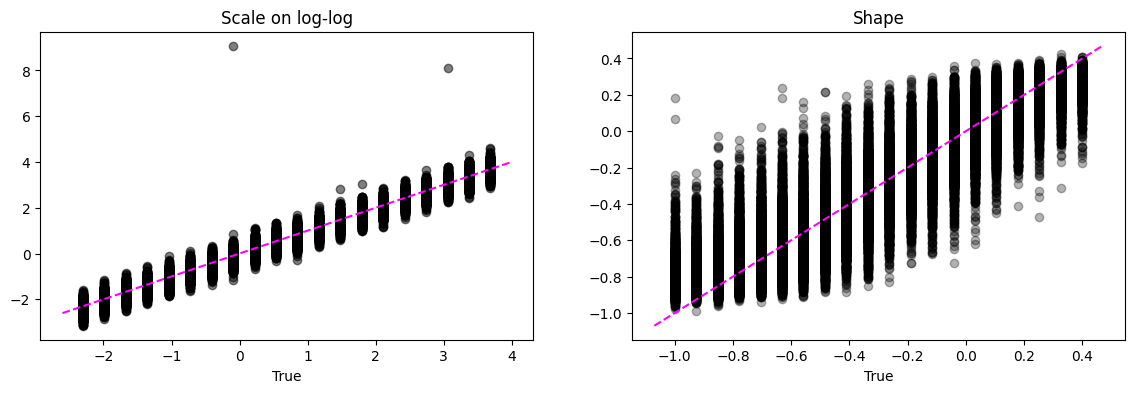

In [39]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_30_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_30_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()
#f.savefig('Using3DiffAF-Mean-IQR.jpg', bbox_inches='tight',dpi=1200)

In [92]:
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
# np.savetxt("pred_loc_30_NN_set3.csv",  pred_loc_30_, delimiter=",")
np.savetxt("pred_scale_30_NN_set3.csv",  pred_scale_30_, delimiter=",")
np.savetxt("pred_shape_30_NN_set3.csv",  pred_shape_30_, delimiter=",")

# # Save the array to a binary file
# np.save('Sample_test_30_.npy', sample_30_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


In [93]:
np.repeat(scale_test.reshape((-1,1)), 100, axis=1).shape

(400, 100)

### Test sample for sample size 72

In [94]:
## # -- Computing the Count Matrix --
M = 100 # M stand for the number of repitition

pred_loc_72_= np.empty((len(shape_test), M))
pred_shape_72_= np.empty((len(shape_test), M))
pred_scale_72_= np.empty((len(shape_test), M))
sample_72_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest72, storeStdSampleTest72, percentileMatTest72, sampleMeansTest72, sampleMediansTest72, sampleIQRsTest72 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                                            shape=shape_test[i],
                                                                                                                                                            loc=loc_test[i],
                                                                                                                                                            scale=scale_test[i],
                                                                                                                                                            p_vec=p_set3,
                                                                                                                                                            N=72,
                                                                                                                                                            M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test72 = np.nanmin(storeStdSampleTest72, axis=1)
  std_sample_max_test72 = np.nanmax(storeStdSampleTest72, axis=1)

  # Calculate the sample minimum and maximum
  sample_min_test72 = np.nanmin(storeSampleTest72, axis=1)
  sample_max_test72 = np.nanmax(storeSampleTest72, axis=1)

  # Transformed parameter values
  sc_loc_test72 = (loc_test[i]/sampleIQRsTest72) - (sampleMediansTest72/sampleIQRsTest72)
  sc_scale_test72 = scale_test[i]/sampleIQRsTest72

  # Checking for frechet or weibull distribution:
  is_weibull_test72 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test72 = np.log(sc_scale_test72 - shape_test[i]*(std_sample_min_test72  - sc_loc_test72))
  delta_weibull_test72 = np.log(sc_scale_test72 - shape_test[i]*(std_sample_max_test72  - sc_loc_test72))
  delta_test72 = np.where(is_weibull_test72, delta_weibull_test72, delta_frechet_test72)

  # Fixing the dimension of the shape parameter
  shape_test72 = np.repeat(shape_test[i], len(sc_scale_test72))

  # -- Test Dataset --
  Z_test72 = percentileMatTest72
  sample_test72 = storeSampleTest72
  sample_72_over_rep[i,:,:] = sample_test72

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test72 = np.transpose((sc_loc_test72,
                            delta_test72,
                            shape_test72))


  tensors_test72 = Z_test72, Y_test72
  test_dataset72 = tf.data.Dataset.from_tensor_slices(tensors_test72).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset72, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals72 = model.predict(Z_test72) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals72 = pred_vals72[:,0]
  delta_pred_vals72 = pred_vals72[:,1]
  shape_pred_vals72 = pred_vals72[:,2]

  # Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred72 = shape_pred_vals72  > mch_epsilon
  is_frechet_pred72 = shape_pred_vals72  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals72 = (shape_pred_vals72*(std_sample_min_test72 - sc_loc_pred_vals72)) + np.exp(delta_pred_vals72)
  # for weibull
  sc_scale_weibull_pred_vals72 = (shape_pred_vals72*(std_sample_max_test72 - sc_loc_pred_vals72)) + np.exp(delta_pred_vals72)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals72 = np.where(is_weibull_pred72, sc_scale_weibull_pred_vals72, sc_scale_frechet_pred_vals72)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals72 = np.array(sc_loc_pred_vals72)*np.array(sampleIQRsTest72) + sampleMeansTest72
  scale_pred_vals72 = np.array(sc_scale_pred_vals72)*np.array(sampleIQRsTest72)

  ## Check for violation in domain condition
  temp72 = loc_pred_vals72.reshape((-1,1)) + (scale_pred_vals72.reshape((-1,1))/shape_pred_vals72.reshape((-1,1)))
  temp_frechet72 = (temp[is_frechet_pred72==True]).reshape((-1,1))
  temp_weibull72 = (temp[is_weibull_pred72==True]).reshape((-1,1))

  sample_test_min_frechet72 = sample_min_test72[is_frechet_pred72==True]
  sample_test_max_weibull72 = sample_max_test72[is_weibull_pred72==True]

  I_frechet72 = np.greater(sample_test_min_frechet72, temp_frechet72)
  A_frechet72 = np.sum(I_frechet72) #(test size, ) # taking intersection of all the event
  I_weibull72 = np.less(sample_test_max_weibull72, temp_weibull72)
  A_weibull72 = np.sum(I_weibull72) #(test size, ) # taking intersection of all the event

  # Total # violation in domain constrain
  TV72= (I_weibull72.shape[0]+I_frechet72.shape[0] - A_weibull72- A_frechet72)

  if TV72>0:
     print('Overall violation in domain constrain (in %)', (TV72*100/(I_weibull72.shape[0]+I_frechet72.shape[0])))

  pred_loc_72_[i,:] =  loc_pred_vals72
  pred_scale_72_[i,:] =  scale_pred_vals72
  pred_shape_72_[i,:] = shape_pred_vals72
  tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 9ms/step
Overall violation in domain constrain (in %) 100.0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 11ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain co

<ipython-input-95-220999580eee>:7: RuntimeWarning: invalid value encountered in log
  np.log(pred_scale_72_),


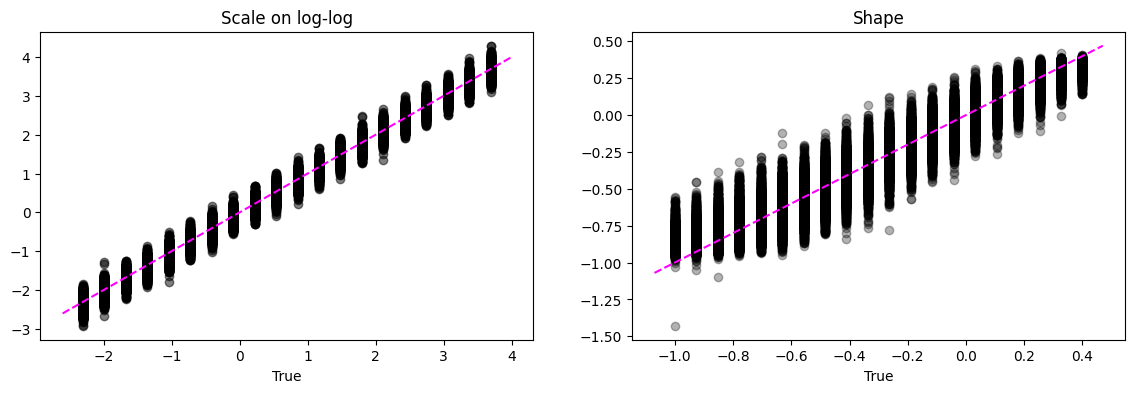

In [95]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_72_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_72_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [ ]:
# # load rb file
# data_72 = np.load('Sample_test_72_.npy')
# np.shape(data_72)
# # Reshape the 3D array to a 2D matrix
# sample_test_72 = data_72.reshape(np.shape(data_72)[0], -1)
# print('2D', sample_test_72.shape)
# np.savetxt("sample_test_72_.csv", sample_test_72, delimiter=",")

In [96]:
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
# np.savetxt("pred_loc_72_NN_set2.csv",  pred_loc_72_, delimiter=",")
np.savetxt("pred_scale_72_NN_set3.csv",  pred_scale_72_, delimiter=",")
np.savetxt("pred_shape_72_NN_set3.csv",  pred_shape_72_, delimiter=",")

# # Save the array to a binary file
# np.save('Sample_test_72_.npy', sample_72_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


### Test sample for sample size 173

In [97]:
##  -- Computing the Count Matrix --
M = 100 # M stand for the number of repitition

pred_loc_173_= np.empty((len(shape_test), M))
pred_shape_173_= np.empty((len(shape_test), M))
pred_scale_173_= np.empty((len(shape_test), M))

sample_173_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest173, storeStdSampleTest173, percentileMatTest173, sampleMeansTest173, sampleMediansTest173, sampleIQRsTest173 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                                                  shape=shape_test[i],
                                                                                                                                                                  loc=loc_test[i],
                                                                                                                                                                  scale=scale_test[i],
                                                                                                                                                                  p_vec=p_set3,
                                                                                                                                                                  N=173,
                                                                                                                                                                  M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test173 = np.nanmin(storeStdSampleTest173, axis=1)
  std_sample_max_test173 = np.nanmax(storeStdSampleTest173, axis=1)

  # Calculate the sample minimum and maximum
  sample_min_test173 = np.nanmin(storeSampleTest173, axis=1)
  sample_max_test173 = np.nanmax(storeSampleTest173, axis=1)

  # Transformed parameter values
  sc_loc_test173 = (loc_test[i]/sampleIQRsTest173) - (sampleMediansTest173/sampleIQRsTest173)
  sc_scale_test173 = scale_test[i]/sampleIQRsTest173

  # Checking for frechet or weibull distribution:
  is_weibull_test173 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test173 = np.log(sc_scale_test173 - shape_test[i]*(std_sample_min_test173  - sc_loc_test173))
  delta_weibull_test173 = np.log(sc_scale_test173 - shape_test[i]*(std_sample_max_test173  - sc_loc_test173))
  delta_test173 = np.where(is_weibull_test173, delta_weibull_test173, delta_frechet_test173)

  # Fixing the dimension of the shape parameter
  shape_test_173 = np.repeat(shape_test[i], len(sc_scale_test173))

  # -- Test Dataset --
  Z_test173 = percentileMatTest173
  sample_test173 = storeSampleTest173
  sample_173_over_rep[i,:,:] = sample_test173

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test173 = np.transpose((sc_loc_test173,
                            delta_test173,
                            shape_test_173))

  # tensors_test173= Z_test173, Y_test173, sample_test173
  tensors_test173 = Z_test30, Y_test30
  test_dataset173 = tf.data.Dataset.from_tensor_slices(tensors_test173).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset173, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals173= model.predict(Z_test173) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals173 = pred_vals173[:,0]
  delta_pred_vals173 = pred_vals173[:,1]
  shape_pred_vals173 = pred_vals173[:,2]

  # Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred173 = shape_pred_vals173 > mch_epsilon
  is_frechet_pred173 = shape_pred_vals173 < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals173 = (shape_pred_vals173*(std_sample_min_test173 - sc_loc_pred_vals173)) + np.exp(delta_pred_vals173)
  # for weibull
  sc_scale_weibull_pred_vals173 = (shape_pred_vals173*(std_sample_max_test173 - sc_loc_pred_vals173)) + np.exp(delta_pred_vals173)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals173 = np.where(is_weibull_pred173, sc_scale_weibull_pred_vals173, sc_scale_frechet_pred_vals173)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals173 = np.array(sc_loc_pred_vals173)*np.array(sampleIQRsTest173) + sampleMeansTest173
  scale_pred_vals173 = np.array(sc_scale_pred_vals173)*np.array(sampleIQRsTest173)

  ## Check for violation in domain condition
  temp173 = loc_pred_vals173.reshape((-1,1)) + (scale_pred_vals173.reshape((-1,1))/shape_pred_vals173.reshape((-1,1)))
  temp_frechet173 = (temp[is_frechet_pred173==True]).reshape((-1,1))
  temp_weibull173 = (temp[is_weibull_pred173==True]).reshape((-1,1))

  sample_test_min_frechet173 = sample_min_test173[is_frechet_pred173==True]
  sample_test_max_weibull173 = sample_max_test173[is_weibull_pred173==True]

  I_frechet173 = np.greater(sample_test_min_frechet173, temp_frechet173)
  A_frechet173 = np.sum(I_frechet173) #(test size, ) # taking intersection of all the event
  I_weibull173 = np.less(sample_test_max_weibull173, temp_weibull173)
  A_weibull173 = np.sum(I_weibull173) #(test size, ) # taking intersection of all the event

  # Total # violation in domain constrain
  TV173= (I_weibull173.shape[0]+I_frechet173.shape[0] - A_weibull173- A_frechet173)

  if TV173>0:
     print('Overall violation in domain constrain (in %)', (TV173*100/(I_weibull173.shape[0]+I_frechet173.shape[0])))

  pred_loc_173_[i,:] =  loc_pred_vals173
  pred_scale_173_[i,:] =  scale_pred_vals173
  pred_shape_173_[i,:] = shape_pred_vals173

tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 9ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain con

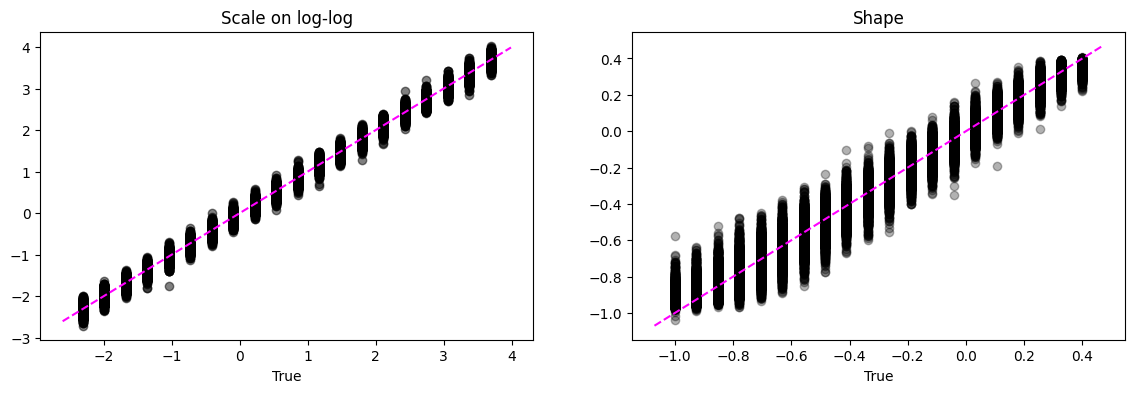

In [98]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_173_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_173_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [99]:
#np.savetxt("pred_loc_173_NN_andrew.csv",  pred_loc_173_, delimiter=",")
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
np.savetxt("pred_scale_173_NN_set3.csv",  pred_scale_173_, delimiter=",")
np.savetxt("pred_shape_173_NN_set3.csv",  pred_shape_173_, delimiter=",")

# # Save the array to a binary file
# np.save('Sample_test_173_.npy', sample_173_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


### Test sample for sample size 416

In [100]:
## # -- Computing the Count Matrix --
M = 100 # M stand for the number of repitition

pred_loc_416_= np.empty((len(shape_test), M))
pred_shape_416_= np.empty((len(shape_test), M))
pred_scale_416_= np.empty((len(shape_test), M))
sample_416_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest416, storeStdSampleTest416, percentileMatTest416, sampleMeansTest416, sampleMediansTest416, sampleIQRsTest416 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                                                  shape=shape_test[i],
                                                                                                                                                                  loc=loc_test[i],
                                                                                                                                                                  scale=scale_test[i],
                                                                                                                                                                  p_vec=p_set3,
                                                                                                                                                                  N=416,
                                                                                                                                                                  M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test416 = np.nanmin(storeStdSampleTest416, axis=1)
  std_sample_max_test416 = np.nanmax(storeStdSampleTest416, axis=1)

  # Calculate the std sample minimum and maximum
  sample_min_test416 = np.nanmin(storeSampleTest416, axis=1)
  sample_max_test416 = np.nanmax(storeSampleTest416, axis=1)

  # Transformed parameter values
  sc_loc_test416 = (loc_test[i]/sampleIQRsTest416) - (sampleMediansTest416/sampleIQRsTest416)
  sc_scale_test416 = scale_test[i]/sampleIQRsTest416

  # Checking for frechet or weibull distribution:
  is_weibull_test416 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test416 = np.log(sc_scale_test416 - shape_test[i]*(std_sample_min_test416  - sc_loc_test416))
  delta_weibull_test416 = np.log(sc_scale_test416 - shape_test[i]*(std_sample_max_test416  - sc_loc_test416))
  delta_test416 = np.where(is_weibull_test416, delta_weibull_test416, delta_frechet_test416)

  # Fixing the dimension of the shape parameter
  shape_test416 = np.repeat(shape_test[i], len(sc_scale_test416))

  # -- Test Dataset --
  Z_test416 = percentileMatTest416
  sample_test416 = storeSampleTest416
  sample_416_over_rep[i,:,:] = sample_test416

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test416 = np.transpose((sc_loc_test416,
                            delta_test416,
                            shape_test416))

  # tensors_test30= Z_test30, Y_test30, sample_test30
  tensors_test416 = Z_test416, Y_test416
  test_dataset416 = tf.data.Dataset.from_tensor_slices(tensors_test416).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset416, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals416 = model.predict(Z_test416) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals416 = pred_vals416[:,0]
  delta_pred_vals416 = pred_vals416[:,1]
  shape_pred_vals416 = pred_vals416[:,2]

  # Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred416 = shape_pred_vals416  > mch_epsilon
  is_frechet_pred416 = shape_pred_vals416  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals416 = (shape_pred_vals416*(std_sample_min_test416 - sc_loc_pred_vals416)) + np.exp(delta_pred_vals416)
  # for weibull
  sc_scale_weibull_pred_vals416 = (shape_pred_vals416*(std_sample_max_test30 - sc_loc_pred_vals416)) + np.exp(delta_pred_vals416)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals416 = np.where(is_weibull_pred416, sc_scale_weibull_pred_vals416, sc_scale_frechet_pred_vals416)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals416 = np.array(sc_loc_pred_vals416)*np.array(sampleIQRsTest416) + sampleMeansTest416
  scale_pred_vals416 = np.array(sc_scale_pred_vals416)*np.array(sampleIQRsTest416)

   ## Check for violation in domain condition
  temp416 = loc_pred_vals416.reshape((-1,1)) + (scale_pred_vals416.reshape((-1,1))/shape_pred_vals416.reshape((-1,1)))
  temp_frechet416 = (temp[is_frechet_pred416==True]).reshape((-1,1))
  temp_weibull416 = (temp[is_weibull_pred416==True]).reshape((-1,1))

  sample_test_min_frechet416 = sample_min_test416[is_frechet_pred416==True]
  sample_test_max_weibull416 = sample_max_test416[is_weibull_pred416==True]

  I_frechet416 = np.greater(sample_test_min_frechet416, temp_frechet416)
  A_frechet416 = np.sum(I_frechet416) #(test size, ) # taking intersection of all the event
  I_weibull416 = np.less(sample_test_max_weibull416, temp_weibull416)
  A_weibull416 = np.sum(I_weibull416) #(test size, ) # taking intersection of all the event

  # Total # violation in domain constrain
  TV416= (I_weibull416.shape[0]+I_frechet416.shape[0] - A_weibull416 - A_frechet416)

  if TV416>0:
     print('Overall violation in domain constrain (in %)', (TV416*100/(I_weibull416.shape[0]+I_frechet416.shape[0])))

  pred_loc_416_[i,:] =  loc_pred_vals416
  pred_scale_416_[i,:] =  scale_pred_vals416
  pred_shape_416_[i,:] = shape_pred_vals416
  tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 9ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 11ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain co

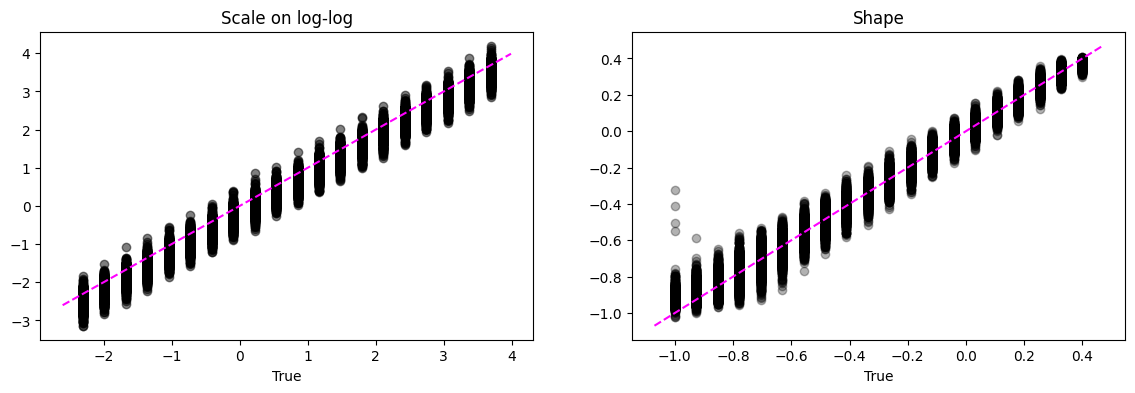

In [101]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_416_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_416_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [102]:
# np.savetxt("pred_loc_416_NN_andrew.csv",  pred_loc_416_, delimiter=",")
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
np.savetxt("pred_scale_416_NN_set3.csv",  pred_scale_416_, delimiter=",")
np.savetxt("pred_shape_416_NN_set3.csv",  pred_shape_416_, delimiter=",")

# Save the array to a binary file
#np.save('Sample_test_416_.npy', sample_416_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


### Test sample for sample size 1000

In [103]:
## # -- Computing the Count Matrix --
# # Working with sample size N_set
# # record time
batch_size=64

M = 100 # M stand for the number of repitition

pred_loc_1000_= np.empty((len(shape_test), M))
pred_shape_1000_= np.empty((len(shape_test), M))
pred_scale_1000_= np.empty((len(shape_test), M))
sample_1000_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest1000, storeStdSampleTest1000, percentileMatTest1000, sampleMeansTest1000, sampleMediansTest1000, sampleIQRsTest1000 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                                                  shape=shape_test[i],
                                                                                                                                                                  loc=loc_test[i],
                                                                                                                                                                  scale=scale_test[i],
                                                                                                                                                                  p_vec=p_set3,
                                                                                                                                                                  N=1000,
                                                                                                                                                                  M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test1000 = np.nanmin(storeStdSampleTest1000, axis=1)
  std_sample_max_test1000 = np.nanmax(storeStdSampleTest1000, axis=1)

  # Calculate the std sample minimum and maximum
  sample_min_test1000 = np.nanmin(storeSampleTest1000, axis=1)
  sample_max_test1000 = np.nanmax(storeSampleTest1000, axis=1)

  # Transformed parameter values
  sc_loc_test1000 = (loc_test[i]/sampleIQRsTest1000) - (sampleMediansTest1000/sampleIQRsTest1000)
  sc_scale_test1000 = scale_test[i]/sampleIQRsTest1000

  # Checking for frechet or weibull distribution:
  is_weibull_test1000 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test1000 = np.log(sc_scale_test1000 - shape_test[i]*(std_sample_min_test1000  - sc_loc_test1000))
  delta_weibull_test1000 = np.log(sc_scale_test1000 - shape_test[i]*(std_sample_max_test1000  - sc_loc_test1000))
  delta_test1000 = np.where(is_weibull_test1000, delta_weibull_test1000, delta_frechet_test1000)

  # Fixing the dimension of the shape parameter
  shape_test1000 = np.repeat(shape_test[i], len(sc_scale_test1000))

  # -- Test Dataset --
  Z_test1000 = percentileMatTest1000
  sample_test1000 = storeSampleTest1000
  sample_1000_over_rep[i,:,:] = sample_test1000

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test1000 = np.transpose((sc_loc_test1000,
                            delta_test1000,
                            shape_test1000))

  # tensors_test30= Z_test30, Y_test30, sample_test30
  tensors_test1000 = Z_test1000, Y_test1000
  test_dataset1000 = tf.data.Dataset.from_tensor_slices(tensors_test1000).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset1000, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals1000 = model.predict(Z_test1000) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals1000 = pred_vals1000[:,0]
  delta_pred_vals1000 = pred_vals1000[:,1]
  shape_pred_vals1000 = pred_vals1000[:,2]

  # Converting delta_pred_vals1000 to sc_scale_pred_vals1000
  is_weibull_pred1000 = shape_pred_vals1000  > mch_epsilon
  is_frechet_pred1000 = shape_pred_vals1000  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals1000 = (shape_pred_vals1000*(std_sample_min_test1000 - sc_loc_pred_vals1000)) + np.exp(delta_pred_vals1000)
  # for weibull
  sc_scale_weibull_pred_vals1000 = (shape_pred_vals1000*(std_sample_max_test1000 - sc_loc_pred_vals1000)) + np.exp(delta_pred_vals1000)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals1000 = np.where(is_weibull_pred1000, sc_scale_weibull_pred_vals1000, sc_scale_frechet_pred_vals1000)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals1000 = np.array(sc_loc_pred_vals1000)*np.array(sampleIQRsTest1000) + sampleMeansTest1000
  scale_pred_vals1000 = np.array(sc_scale_pred_vals1000)*np.array(sampleIQRsTest1000)


  ## Check for violation in domain condition
  temp1000 = loc_pred_vals1000.reshape((-1,1)) + (scale_pred_vals1000.reshape((-1,1))/shape_pred_vals1000.reshape((-1,1)))
  temp_frechet1000 = (temp[is_frechet_pred1000==True]).reshape((-1,1))
  temp_weibull1000 = (temp[is_weibull_pred1000==True]).reshape((-1,1))

  sample_test_min_frechet1000 = sample_min_test1000[is_frechet_pred1000==True]
  sample_test_max_weibull1000 = sample_max_test1000[is_weibull_pred1000==True]

  I_frechet1000 = np.greater(sample_test_min_frechet1000, temp_frechet1000)
  A_frechet1000 = np.sum(I_frechet1000) #(test size, ) # taking intersection of all the event
  I_weibull1000 = np.less(sample_test_max_weibull1000, temp_weibull1000)
  A_weibull1000 = np.sum(I_weibull1000) #(test size, ) # taking intersection of all the event

  # Total # violation in domain constrain
  TV1000= (I_weibull1000.shape[0]+I_frechet1000.shape[0] - A_weibull1000 - A_frechet1000)

  if TV1000>0:
     print('Overall violation in domain constrain (in %)', (TV1000*100/(I_weibull1000.shape[0]+I_frechet1000.shape[0])))

  pred_loc_1000_[i,:] =  loc_pred_vals1000
  pred_scale_1000_[i,:] =  scale_pred_vals1000
  pred_shape_1000_[i,:] = shape_pred_vals1000
  tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain con

In [104]:
# np.savetxt("pred_loc_1000_NN_andrew.csv",  pred_loc_1000_, delimiter=",")
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
np.savetxt("pred_scale_1000_NN_set3.csv",  pred_scale_1000_, delimiter=",")
np.savetxt("pred_shape_1000_NN_set3.csv",  pred_shape_1000_, delimiter=",")

# Save the array to a binary file
# np.save('Sample_test_1000_.npy', sample_1000_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


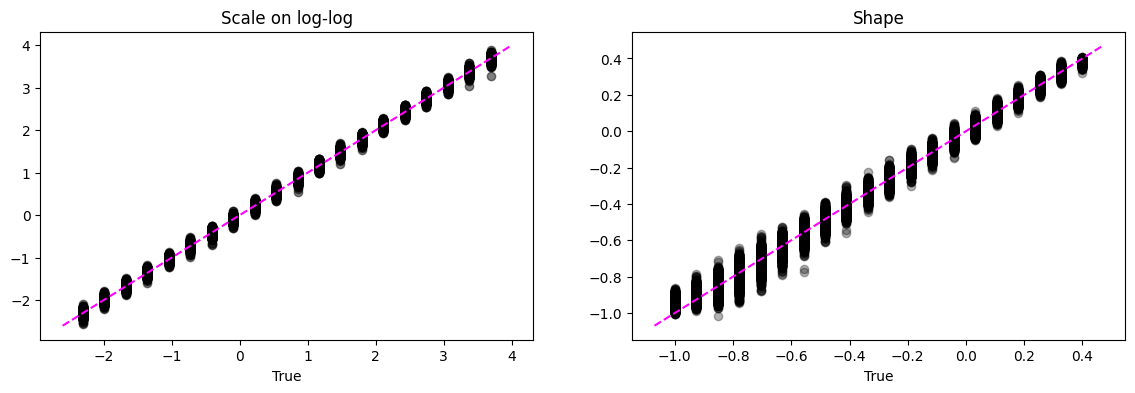

In [105]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_1000_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_1000_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

### Bootstrap

In [40]:
# -- Generating sample for repetition -- #
# Function to compute the Count matrix for the standardized data along with the original sample
def repeated_Z_quantiles_plus_sample(seed, shape, loc, scale, p_vec, N, M):
    """
    Function to return 'Quantile matrix' for different simulated sample over same parameter
    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape, loc, scale_vec = simulated shape, location, scale parameter value
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!

    * p_vec = quantile set
    * N = GEV sample generated for each parameter combination
      -> is set to 100 for now.
    * M = no of repeatation in general
    """
    # setting the seed for sample generation
    random.seed(seed)

    # -- initializing the matrices & vectors --
    percentile_Matrix = np.empty((M,len(p_vec)))# store the counts
    storeSample = np.empty((M, N)) # store original sample
    storeStdSample = np.empty((M, N)) # store original sample

    storeIqr = [] # store sample IQR
    storeMedian = [] # store sample MEDIAN

    storeStdMin = []
    storeStdMax = []

    # -- extracting counts --
    for i in range(M):

        # sample generation
        X_sample = gev.rvs(c=shape,
                           loc=loc,
                           scale=scale,
                           size=N)

        # computing sample Median and IQR
        Median_sample = np.median(X_sample)
        Iqr_sample = scipy.stats.iqr(X_sample)


        storeMedian.append(Median_sample)
        storeIqr.append(Iqr_sample)

        # standardization of the data
        Z_sample = (X_sample-Median_sample)/Iqr_sample
        percentile_Matrix[i,:] = np.percentile(Z_sample, p_vec*np.array(100))

        storeSample[i, :] = X_sample # dimension n*1000
        storeStdSample[i, :] = Z_sample

        storeStdMin.append(np.min(Z_sample))
        storeStdMax.append(np.max(Z_sample))

        # storeStdSample[i, :] = Z_sample # dimension n*1000
        # storeSample[i, :]= X_sample # dimension n*1000
        # storeStdSample[i, :]= Z_sample # dimension n*1000

        # # store std sample
        # if len(X_sample)==1000:
        #     # storing the sample
        #     storeSample[i, :] = X_sample # dimension n*1000
        #     storeStdSample[i, :] = Z_sample # dimension n*1000
        # else:
        #     # we are working with varying sample size
        #     # some elements in the matrix will have NaN values
        #     fill_space_NaN = np.empty((1000-len(X_sample)))
        #     fill_space_NaN[:] = np.NaN
        #     storeSample[i,:] = np.concatenate((X_sample, fill_space_NaN))
        #     storeStdSample[i, :] = np.concatenate((Z_sample, fill_space_NaN))

    return storeSample, storeStdSample, percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeStdMin), np.array(storeStdMax)

In [41]:
# -- Generating sample for Bootstrap Sample to avoid looping -- #
# Function to compute the Count matrix for the standardized data
def boot_Z_quantiles(seed, shape, loc, scale, p_vec, N, B):
    """
    Function to return 'Quantile matrix' for different simulated sample over same parameter
    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape, loc, scale_vec = simulated shape, location, scale parameter value
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!

    * p_vec = quantile set
    * N = GEV sample generated for each parameter combination
      -> is set to 100 for now.
    * B = no of bootstrap repeatations
    """
    # setting the seed for sample generation
    random.seed(seed)

    # -- initializing the matrices & vectors --
    percentile_Matrix = np.empty((B,len(p_vec)))# store the counts
    storeIqr = [] # store sample IQR
    storeMedian = [] # store sample MEDIAN

    storeZmin = [] # store sample MEDIAN
    storeZmax = [] # store sample MEDIAN

    # -- extracting counts --
    for i in range(B):

        # sample generation
        X_sample = gev.rvs(c=shape,
                           loc=loc,
                           scale=scale,
                           size=N)
        #print(X_sample)
        # computing sample Median and IQR
        Median_sample = np.median(X_sample)
        Iqr_sample = scipy.stats.iqr(X_sample)

        storeMedian.append(Median_sample)
        storeIqr.append(Iqr_sample)

        # standardization of the data
        Z_sample = (X_sample-Median_sample)/Iqr_sample
        storeZmin.append(np.min(Z_sample))
        storeZmax.append(np.max(Z_sample))

        percentile_Matrix[i,:] = np.percentile(Z_sample, p_vec*np.array(100))

    return percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeZmin), np.array(storeZmax)

In [ ]:
# random.seed(123)
# n_test = 25
# shape_test = random.uniform(-1, 0.4, n_test)
# scale_test = 10**random.uniform(np.log10(0.1), np.log10(40), n_test)
# loc_test = random.uniform(1, 50, n_test)

In [64]:
# Generating the parameter configuration for evaluation of the network architecture
# we want to set on a 20X20 grid across the scale and shape parameter
test_grid_size= 4
loc_vals = np.linspace(1, 50, test_grid_size) # changed from -1 to -0.8
shape_vals= np.linspace(-0.8, 0.4, test_grid_size) # changed from -1 to -0.8
scale_vals= 10**np.linspace(np.log10(0.1), np.log10(40), test_grid_size)

from itertools import product
# loc value = 0
# Get all combinations using itertools.product()
grid_loc_scale_shape = np.array(list(product(loc_vals, scale_vals, shape_vals)))
print(grid_loc_scale_shape.shape)

# Perhaps the test parameters to evaluate the NN are:
loc_test = grid_loc_scale_shape[:,0]
scale_test= grid_loc_scale_shape[:,1]
shape_test= grid_loc_scale_shape[:,2]

print('loc_test', loc_test)
print('scale_test', scale_test)
print('shape_test', shape_test)

(64, 3)
loc_test [ 1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.         17.33333333 17.33333333
 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333
 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333
 17.33333333 17.33333333 33.66666667 33.66666667 33.66666667 33.66666667
 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667
 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667
 50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.        ]
scale_test [ 0.1         0.1         0.1         0.1         0.7368063   0.7368063
  0.7368063   0.7368063   5.42883523  5.42883523  5.42883523  5.42883523
 40.         40.         40.         40.          0.1         0.1
  0.1        

In [65]:
boot_test_par = np.transpose(np.vstack((loc_test, scale_test , shape_test)))

In [69]:
# np.savetxt("pred_loc_416_NN_andrew.csv",  pred_loc_416_, delimiter=",")
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
np.savetxt("boot_test_par_over_grid.csv",  boot_test_par, delimiter=",")

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2


In [70]:
tf.random.set_seed(42)
batch_size = 128

M = 100 # M stand for the number of repitition

pred_loc_ = np.empty((len(shape_test), M))
pred_shape_ = np.empty((len(shape_test), M))
pred_scale_ = np.empty((len(shape_test), M))


sample_over_rep = np.empty((len(shape_test), M, 416)) # chnaged from 1000 to 416

start_time= time.time()
for i in range(len(shape_test)):
  print('Parameter Configuration', i)
  # storeSample, storeStdSample, percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeStdMin), np.array(storeStdMax)
  storeSampleTest1000, storeStdSampleTest1000, percentileMatTest1000, sampleMediansTest1000, sampleIQRsTest1000, std_sample_min_test1000, std_sample_max_test1000  = repeated_Z_quantiles_plus_sample(seed=i^5,
                                                                                                                                                                                                      shape=shape_test[i],
                                                                                                                                                                                                      loc=loc_test[i],
                                                                                                                                                                                                      scale=scale_test[i],
                                                                                                                                                                                                      p_vec=p_set2,
                                                                                                                                                                                                      N=416,
                                                                                                                                                                                                      M=M)



  # Convert original sample to standardized sample
  # sampleIQRs_reshaped = sampleIQRsTest1000.reshape(-1, 1)
  # sampleMedians_reshaped =  sampleMediansTest1000.reshape(-1, 1)
  # storeStdSampleTest1000 =  (storeSampleTest1000 - sampleMedians_reshaped)/sampleIQRs_reshaped

  sc_loc_test1000 = (loc_test[i]/sampleIQRsTest1000) - (sampleMediansTest1000/sampleIQRsTest1000)
  sc_scale_test1000 = scale_test[i]/sampleIQRsTest1000

  # Checking for frechet or weibull distribution:
  is_weibull_test1000 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test1000 = np.log(sc_scale_test1000 - shape_test[i]*(std_sample_min_test1000  - sc_loc_test1000))
  delta_weibull_test1000 = np.log(sc_scale_test1000 - shape_test[i]*(std_sample_max_test1000  - sc_loc_test1000))
  delta_test1000 = np.where(is_weibull_test1000, delta_weibull_test1000, delta_frechet_test1000)

  # Fixing the dimension of the shape parameter
  shape_test1000 = np.repeat(shape_test[i], len(sc_scale_test1000))

  # -- Test Dataset --
  Z_test1000 = percentileMatTest1000
  sample_test1000 = storeSampleTest1000
  #sample_1000_over_rep[i,:,:] = sample_test1000

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test1000 = np.transpose((sc_loc_test1000,
                            delta_test1000,
                            shape_test1000))

  # tensors_test30= Z_test30, Y_test30, sample_test30
  tensors_test1000 = Z_test1000, Y_test1000
  test_dataset1000 = tf.data.Dataset.from_tensor_slices(tensors_test1000).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset1000, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals1000 = model.predict(Z_test1000) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals1000 = pred_vals1000[:,0]
  delta_pred_vals1000 = pred_vals1000[:,1]
  shape_pred_vals1000 = pred_vals1000[:,2]

  # Converting delta_pred_vals1000 to sc_scale_pred_vals1000
  is_weibull_pred1000 = shape_pred_vals1000  > mch_epsilon
  is_frechet_pred1000 = shape_pred_vals1000  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals1000 = (shape_pred_vals1000*(std_sample_min_test1000 - sc_loc_pred_vals1000)) + np.exp(delta_pred_vals1000)
  # for weibull
  sc_scale_weibull_pred_vals1000 = (shape_pred_vals1000*(std_sample_max_test1000 - sc_loc_pred_vals1000)) + np.exp(delta_pred_vals1000)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals1000 = np.where(is_weibull_pred1000, sc_scale_weibull_pred_vals1000, sc_scale_frechet_pred_vals1000)
  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals1000 = pred_vals1000[:,0]

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals1000 = np.array(sc_loc_pred_vals1000)*np.array(sampleIQRsTest1000) + sampleMediansTest1000
  scale_pred_vals1000 = np.array(sc_scale_pred_vals1000)*np.array(sampleIQRsTest1000)

  pred_loc_[i,:] = loc_pred_vals1000
  pred_scale_[i,:] = scale_pred_vals1000
  pred_shape_[i,:] = pred_vals1000[:,2]

tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

Parameter Configuration 0
4/4 [==============================] - 0s 4ms/step
Parameter Configuration 1
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 2
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 3
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 4
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 5
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 6
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 7
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 8
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 9
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 10
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 11
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 12
4/4 [==============================] - 0s 3ms/s

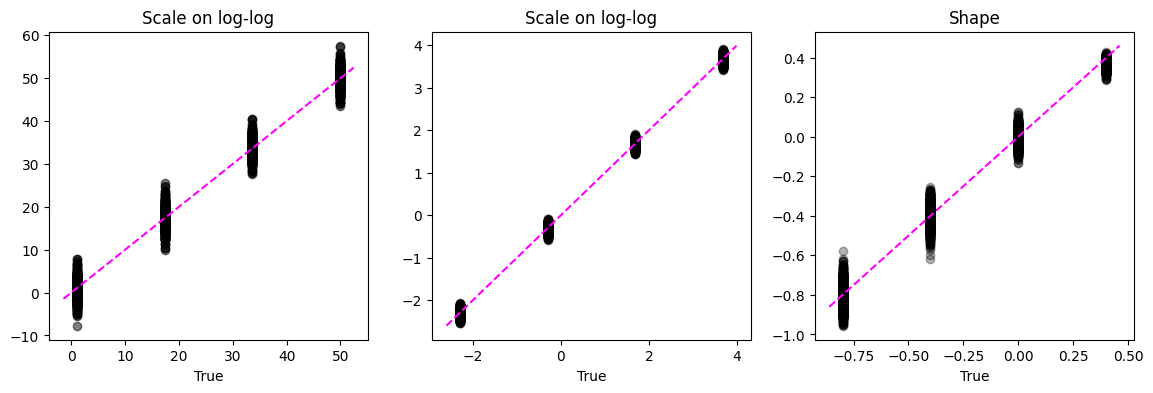

In [71]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
scatter2= plt.scatter(np.repeat(loc_test.reshape((-1,1)), 100, axis=1),
                      pred_loc_,
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,3,2)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [72]:
np.shape(loc_test)

(64,)

In [73]:
B = 1000
print('Bootstrap resampling ', B)

M = pred_loc_.shape[1]
print('Sample repetition', M)

N_test = pred_loc_.shape[0]
print('Test Configuration', N_test)

Bootstrap resampling  1000
Sample repetition 100
Test Configuration 64


In [ ]:
 # -- Bootstrapping for Sample Size 416 --
conf_level = 0.95  # confidence level to calculate the coverage
alpha= 0.05

# Initialized matrix and array
boot_est_test = np.empty((N_test, M, 3)) # store the bootstrap estimates: mu, sigma, and  c
boot_sd_test = np.empty((N_test, M, 3))  # store the bootstrap SE of the estimates: mu, sigma, and  c
boot_return_test = np.empty((N_test, M, 5))  # store the return values of bootstrap estimates for 5 different return levels
boot_return_sd_test = np.empty((N_test, M, 5))  # store the return values of bootstrap estimates for 5 different return levels

boot_CI_lower_loc = np.empty((N_test, M))  # store coverage of the location parameter
boot_CI_lower_scale = np.empty((N_test, M))  # store coverage of the scale parameter
boot_CI_lower_shape = np.empty((N_test, M))  # store coverage of the shape parameter

boot_CI_upper_loc = np.empty((N_test, M))  # store coverage of the location parameter
boot_CI_upper_scale = np.empty((N_test, M))  # store coverage of the scale parameter
boot_CI_upper_shape = np.empty((N_test, M))  # store coverage of the shape parameter

# record time
start_time= time.time()
for i in range(N_test):
  print('Parameter Configuration', i)
  for j in range(M):
    print('Repetition', j)
   #  percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeZmin), np.array(storeZmax)
    # -- Computing the Percentile Matrix for Bootstrap --
    percentileMatBoot, sampleMediansBoot, sampleIQRsBoot, storeZminBoot, storeZmaxBoot = boot_Z_quantiles(seed=i,
                                                                                                          shape=pred_shape_[i,j],
                                                                                                          loc=pred_loc_[i,j],
                                                                                                          scale=pred_scale_[i,j],
                                                                                                          p_vec=p_set2,
                                                                                                          N=416,
                                                                                                          B=B)
    # Bootstrap Estimates
    fitted_vals_boot = model.predict(percentileMatBoot) # dimension (Bx11)

    # scaled estimates of Loc-Scale parameters
    sc_loc_pred_vals_boot = fitted_vals_boot[:,0] # dimension (Bx1)
    delta_pred_vals_boot = fitted_vals_boot[:,1] # dimension (Bx1)
    # sc_scale_pred_vals_boot = fitted_vals_boot[:,1] # dimension (Bx1)
    shape_pred_vals_boot = fitted_vals_boot[:,2]  # dimension (Bx1)

    # Sc- Scale parameter
    # Converting delta_pred_vals1000 to sc_scale_pred_vals1000
    is_weibull_predBoot =  shape_pred_vals_boot  > mch_epsilon

    # for frechet
    sc_scale_frechet_predBoot = (shape_pred_vals_boot*( storeZminBoot - sc_loc_pred_vals_boot)) + np.exp( delta_pred_vals_boot)
    # for weibull
    sc_scale_weibull_predBoot = (shape_pred_vals_boot*( storeZmaxBoot - sc_loc_pred_vals_boot)) + np.exp( delta_pred_vals_boot)

    # Estimate of the transformed scale parameter
    sc_scale_pred_vals_boot = np.where(is_weibull_predBoot, sc_scale_weibull_predBoot,  sc_scale_frechet_predBoot)

    # Back-transformed Loc-Scale parameters
    loc_pred_vals_boot = (sc_loc_pred_vals_boot*sampleIQRsBoot) + sampleMediansBoot # dimension (Bx1)
    scale_pred_vals_boot = sc_scale_pred_vals_boot*sampleIQRsBoot # dimension (Bx1)

    # Storing bootstrap estimates  & standard deviation
    boot_est_test[i,j, ] = [np.mean(loc_pred_vals_boot), np.mean(scale_pred_vals_boot), np.mean(shape_pred_vals_boot)]
    boot_sd_test[i,j, ] = [np.std(loc_pred_vals_boot), np.std(scale_pred_vals_boot), np.std(shape_pred_vals_boot)]

    # Calculate the confidence interval and coverage probability
    # lower_percentile = (1 - conf_level)/2
    # upper_percentile = (1 - lower_percentile)
    lower_percentile = alpha/2
    upper_percentile = 1 - (alpha/2)

    lower_bound_loc = np.quantile(loc_pred_vals_boot, lower_percentile)
    upper_bound_loc = np.quantile(loc_pred_vals_boot, upper_percentile)

    lower_bound_shape = np.quantile(shape_pred_vals_boot, lower_percentile)
    upper_bound_shape = np.quantile(shape_pred_vals_boot, upper_percentile)

    lower_bound_scale = np.quantile(scale_pred_vals_boot, lower_percentile)
    upper_bound_scale = np.quantile(scale_pred_vals_boot, upper_percentile)

    boot_CI_lower_loc[i,j] = lower_bound_loc  # store coverage of the location parameter
    boot_CI_lower_scale[i,j] = lower_bound_scale  # store coverage of the scale parameter
    boot_CI_lower_shape[i,j] = lower_bound_shape  # store coverage of the shape parameter

    boot_CI_upper_loc[i,j] = upper_bound_loc   # store coverage of the location parameter
    boot_CI_upper_scale[i,j] = upper_bound_scale  # store coverage of the scale parameter
    boot_CI_upper_shape[i,j] = upper_bound_shape # store coverage of the shape parameter

    # # Calculate coverage probability
    # coverage_boot_loc[i,j] = np.mean((lower_bound_loc <= loc_test[i]) & (loc_test[i] <= upper_bound_loc))
    # coverage_boot_scale[i,j] = np.mean((lower_bound_scale <= scale_test[i]) & (scale_test[i] <= upper_bound_scale))
    # coverage_boot_shape[i,j] = np.mean((lower_bound_shape <= shape_test[i]) & (shape_test[i] <= upper_bound_shape))

print("--- %s seconds ---" % (time.time()-start_time))
tot_time= (time.time()-start_time)

Streaming output truncated to the last 5000 lines.
Repetition 73
32/32 [==============================] - 0s 2ms/step
Repetition 74
32/32 [==============================] - 0s 3ms/step
Repetition 75
32/32 [==============================] - 0s 2ms/step
Repetition 76
32/32 [==============================] - 0s 3ms/step
Repetition 77
32/32 [==============================] - 0s 2ms/step
Repetition 78
32/32 [==============================] - 0s 3ms/step
Repetition 79
32/32 [==============================] - 0s 3ms/step
Repetition 80
32/32 [==============================] - 0s 3ms/step
Repetition 81
32/32 [==============================] - 0s 3ms/step
Repetition 82
32/32 [==============================] - 0s 3ms/step
Repetition 83
32/32 [==============================] - 0s 3ms/step
Repetition 84
32/32 [==============================] - 0s 3ms/step
Repetition 85
32/32 [==============================] - 0s 3ms/step
Repetition 86
32/32 [==============================] - 0s 3ms/step
Repetition 

In [ ]:
tot_time/3600

In [ ]:
# Check for coverage:
coverage_boot_loc = np.empty((N_test))
coverage_boot_scale = np.empty((N_test))
coverage_boot_shape = np.empty((N_test))
for i in range(N_test):
  print('Parameter Configuration', i)
  for j in range(M):
    print('Repetition', j)

    # Calculate coverage probability
    coverage_boot_loc[i] = np.mean((boot_CI_lower_loc[i,:] < loc_test[i]) & (boot_CI_upper_loc[i,:]> loc_test[i]))
    coverage_boot_scale[i] = np.mean((boot_CI_lower_scale[i,:] < scale_test[i]) & (boot_CI_upper_scale[i,:]> scale_test[i]))
    coverage_boot_shape[i] = np.mean((boot_CI_lower_shape[i,:] < shape_test[i]) & (boot_CI_upper_shape[i,:]> shape_test[i]))

In [ ]:
# np.savetxt("pred_loc_1000_NN_andrew.csv",  pred_loc_1000_, delimiter=",")
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
np.savetxt("coverage_boot_loc_on_grid.csv",  coverage_boot_loc, delimiter=",")
np.savetxt("coverage_boot_scale_on_grid.csv",  coverage_boot_scale, delimiter=",")
np.savetxt("coverage_boot_shape_on_grid.csv",  coverage_boot_shape, delimiter=",")

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2


In [ ]:
# Calculating the bootstap CI width:
boot_CI_width_loc = boot_CI_upper_loc - boot_CI_lower_loc
print("Dimension of the boot_CI_width_loc", np.shape(boot_CI_width_loc))

boot_CI_width_scale = boot_CI_upper_scale - boot_CI_lower_scale
print("Dimension of the boot_CI_width_scale", np.shape(boot_CI_width_scale))

boot_CI_width_shape = boot_CI_upper_shape - boot_CI_lower_shape
print("Dimension of the boot_CI_width_shape", np.shape(boot_CI_width_shape))

In [ ]:
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
np.save("boot_CI_upper_loc.npy",  boot_CI_upper_loc, delimiter=",")
np.save("boot_CI_lower_loc.npy",  boot_CI_lower_loc, delimiter=",")

np.save("boot_CI_upper_scale.npy",  boot_CI_upper_scale, delimiter=",")
np.save("boot_CI_lower_scale.npy",  boot_CI_lower_scale, delimiter=",")

np.save("boot_CI_upper_shape.npy",  boot_CI_upper_shape, delimiter=",")
np.save("boot_CI_lower_shape.npy",  boot_CI_lower_shape, delimiter=",")

In [ ]:
%cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
np.save("boot_CI_width_loc.npy",  boot_CI_width_loc , delimiter=",")
np.save("boot_CI_width_scale.npy", boot_CI_width_scale, delimiter=",")
np.save("boot_CI_width_shape.npy",  boot_CI_width_shape, delimiter=",")

In [ ]:
plt.scatter(loc_test, coverage_boot_loc)

In [ ]:
plt.scatter(scale_test, coverage_boot_scale)

In [ ]:
plt.scatter(shape_test,coverage_boot_shape)

In [63]:
shape_test[np.where(coverage_boot_shape==0)]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.])

### Predicted vs True Plot: SCALED PARAMETERS

ValueError: ignored

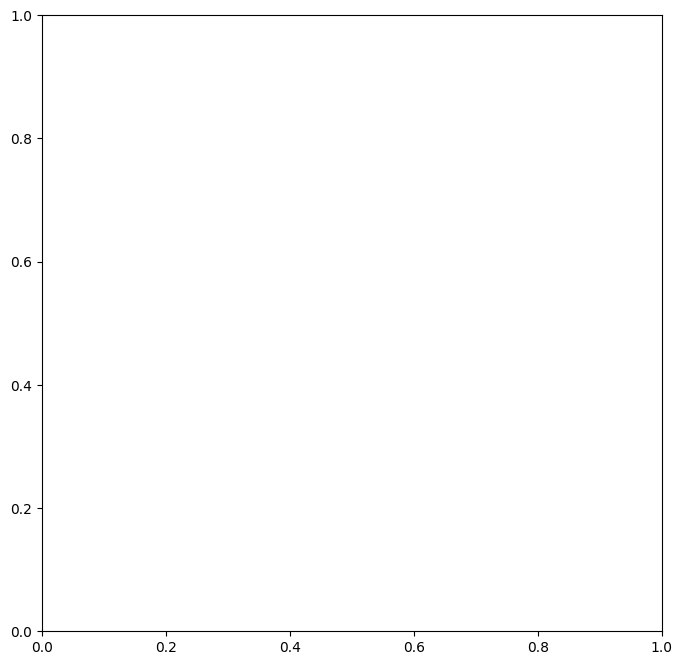

In [ ]:
f= plt.figure(figsize=(8,8))

scatter1= plt.scatter(loc_test,
                      loc_pred_vals,
                      color= 'black',
                      alpha=0.20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(chr(956), fontsize=20)
plt.xlabel('True', fontsize=16)
plt.ylabel('Predict', fontsize=16)
abline(1, 0)

#f.savefig('VSample-Loc-3OP.png', bbox_inches='tight', dpi=1200)

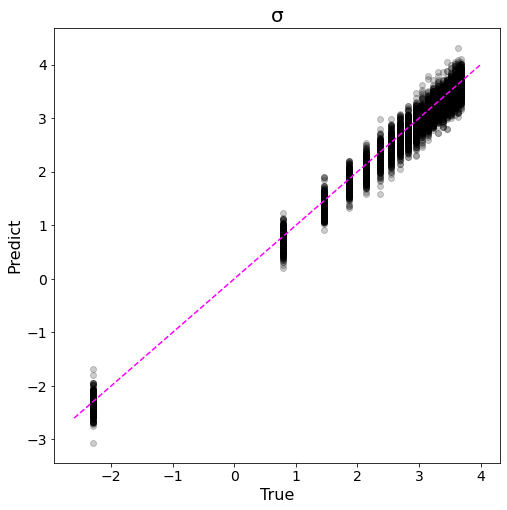

In [ ]:
f= plt.figure(figsize=(8,8))

scatter2= plt.scatter(np.log(scale_test),
                      np.log(scale_pred_vals),
                      color= 'black',
                      alpha=0.20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(chr(963), fontsize=20)
plt.xlabel('True', fontsize=16)
plt.ylabel('Predict', fontsize=16)
abline(1, 0)

#f.savefig('VSample-Scale-3OP.png', bbox_inches='tight', dpi=1200)

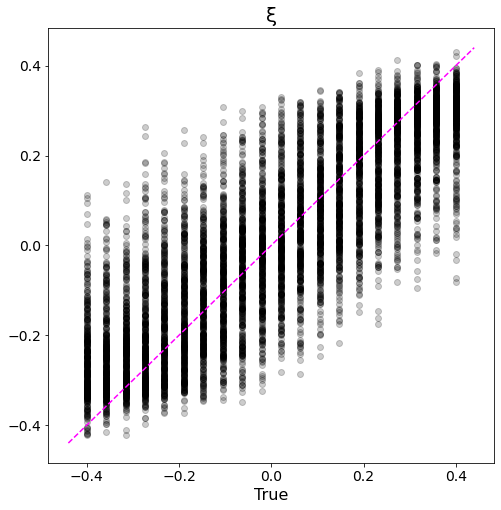

In [ ]:
f= plt.figure(figsize=(8,8))
scatter3= plt.scatter(shape_test,
                      shape_pred_vals,
                      color= 'black',
                      alpha=0.20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(chr(958), fontsize=20)
plt.xlabel('True',fontsize=16)
abline(1, 0)
#f.savefig('VSample-Shape-3OP.png', bbox_inches='tight', dpi=1200)

In [ ]:
sample_test_min = np.min(storeSampleTest, axis=1)
sample_test_max = np.min(storeSampleTest, axis=1)

# Check for violation in Domain constrain of GEV distribution
mch_epsilon = np.finfo(float).eps
print(mch_epsilon)

is_weibull_pred = shape_pred_vals > mch_epsilon
is_frechet_pred = shape_pred_vals < -mch_epsilon

## Check for violation in domain condition
temp = loc_pred_vals.flatten() + (scale_pred_vals.flatten()/shape_pred_vals.flatten())

temp_frechet = (temp[is_frechet_pred==True])
temp_weibull = (temp[is_weibull_pred==True])

sample_test_min_frechet = sample_test_min[is_frechet_pred==True]
sample_test_max_weibull = sample_test_max[is_weibull_pred==True]

I_frechet = np.greater(sample_test_min_frechet, temp_frechet)
A_frechet = np.sum(I_frechet) #(test size, ) # taking intersection of all the event

I_weibull = np.less(sample_test_max_weibull, temp_weibull)
A_weibull = np.sum(I_weibull) #(test size, ) # taking intersection of all the event

# Total # violation in domain constrain
TV= (I_weibull.shape[0]+I_frechet.shape[0] - A_weibull- A_frechet)
print('# of Violation',TV)
if TV>0:
  print('Overall violation in domain constrain (in %)', (TV*100/(I_weibull.shape[0]+I_frechet.shape[0])))

## Predict vs True plot over Sample size set



NameError: ignored

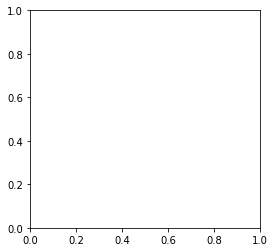

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
scatter1= plt.scatter(loc_test,
                      loc_pred_vals,
                      c=N_test,
                      alpha=0.20)
plt.title('Location')
plt.xlabel('True')
plt.ylabel('Predict')
abline(1, 0)

plt.subplot(1,3,2)
scatter2= plt.scatter(np.log(scale_test),
                      np.log(scale_pred_vals),
                      c=N_test,
                      alpha=0.20)
plt.title('Scale')
plt.xlabel('True')
abline(1, 0)

plt.subplot(1,3,3)
scatter3= plt.scatter(shape_test,
                      shape_pred_vals,
                      c=N_test,
                      alpha=0.20)
plt.title('Shape')
plt.xlabel('True')
plt.legend(handles= scatter3.legend_elements(alpha= 0.7)[0],
           labels=[N_set[0], N_set[1],N_set[2], N_set[3],N_set[4]],
           loc='center left',
           bbox_to_anchor=(1.1 , 0.5),
           title='Sample size')
abline(1, 0)
plt.tight_layout()
plt.show()

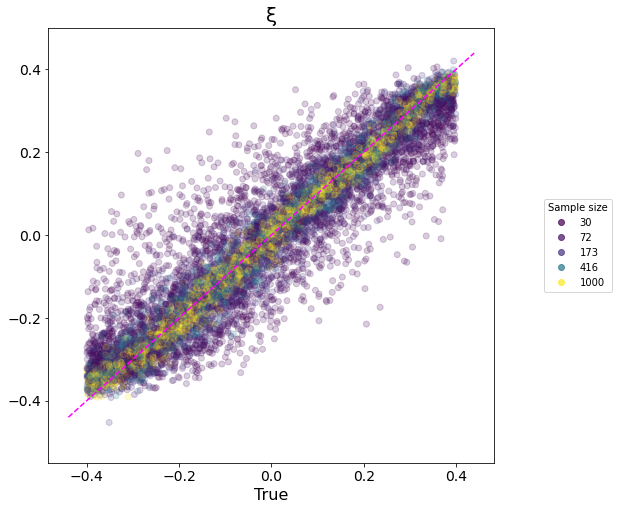

In [ ]:
f= plt.figure(figsize=(8,8))
scatter3= plt.scatter(shape_test,
                      shape_pred_vals,
                      c=N_test,
                      alpha=0.20)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(chr(958), fontsize=20)
plt.xlabel('True',fontsize=16)
plt.ylim(-0.55, 0.5)
abline(1, 0)
plt.legend(handles= scatter3.legend_elements(alpha= 0.7)[0],
           labels=[N_set[0], N_set[1],N_set[2], N_set[3],N_set[4]],
           loc='center left',
           bbox_to_anchor=(1.1 , 0.5),
           title='Sample size')
#f.savefig('VaryingSample-Shape-3OP.png', bbox_inches='tight', dpi=1200)

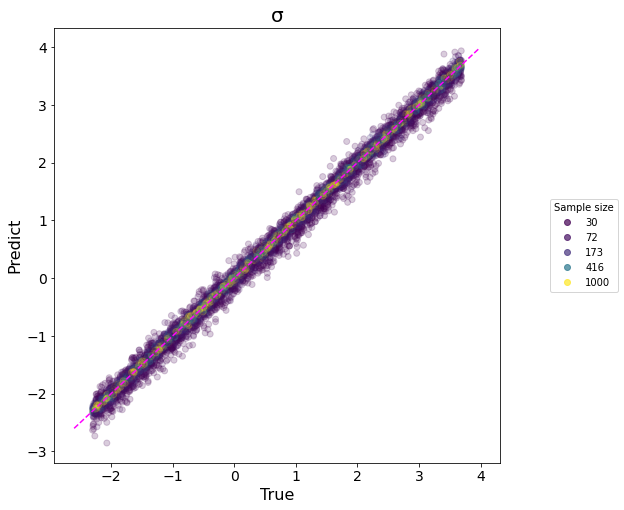

In [ ]:
f= plt.figure(figsize=(8,8))

scatter2= plt.scatter(np.log(scale_test),
                      np.log(scale_pred_vals),
                      c=N_test,
                      alpha=0.20)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(chr(963), fontsize=20)
plt.xlabel('True', fontsize=16)
plt.ylabel('Predict', fontsize=16)
abline(1, 0)
plt.legend(handles= scatter2.legend_elements(alpha= 0.7)[0],
           labels=[N_set[0], N_set[1],N_set[2], N_set[3],N_set[4]],
           loc='center left',
           bbox_to_anchor=(1.1 , 0.5),
           title='Sample size')
#f.savefig('VSample-Scale-3OP.png', bbox_inches='tight', dpi=1200)

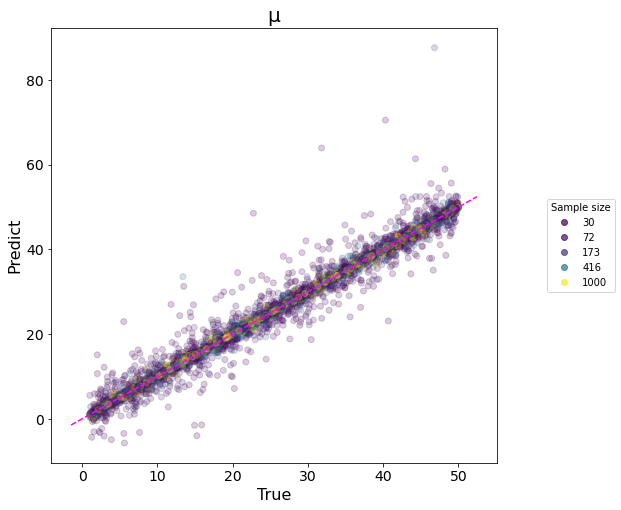

In [ ]:
f= plt.figure(figsize=(8,8))

scatter1= plt.scatter(loc_test,
                      loc_pred_vals,
                      c=N_test,
                      alpha=0.20)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(chr(956), fontsize=20)
plt.xlabel('True', fontsize=16)
plt.ylabel('Predict', fontsize=16)
abline(1, 0)
plt.legend(handles= scatter1.legend_elements(alpha= 0.7)[0],
           labels=[N_set[0], N_set[1],N_set[2], N_set[3],N_set[4]],
           loc='center left',
           bbox_to_anchor=(1.1 , 0.5),
           title='Sample size')
#f.savefig('VSample-Loc-3OP.png', bbox_inches='tight', dpi=1200)

In [ ]:
def log_likelihood(mu, sigma, c, sample):
  """
  Function defined to find the log-likelihood express of the GEV distribution
  for given loc, scale and shape value(-Xi) give the sample of size n
  Arguments:
  * mu: location parameter
  * sigma: scale parameter
  * c: shape (also c = -Xi)
  * sample:  given data where the likelihood is evaluated
  Returns the log-likelihood value for the given data
  """
  n= len(sample.flatten())
  # CONDITION ON THE SHAPE PARAMETER: CHECKS HOW CLOSE TO ZERO!
  if abs(c) > 1e-8:
    # Computation when "SHAPE!=0"
    L= -n*np.log(sigma) - (c-1/c)*np.sum(np.log(1-c*((sample-mu)/sigma))) - np.sum((1-c*((sample-mu)/sigma))**(1/c))

  else:
    # Computation when "SHAPE!=0"
    L= -n*np.log(sigma) - np.sum((sample-mu)/sigma) - np.sum(np.exp(-(sample-mu)/sigma))
  return L